# **1. Definición del problema**




## 1. Propósito del Proyecto

El objetivo principal de este proyecto es desarrollar un modeloe **Machine Learning de clasificación supervida** para anticipar la dirección del precio de cierre de un activo bursátil, en este caso Tesla, en relación con su precio de apertura en el mismo día.

El objetivo final es evaluar si este clasificador puede:

1.  Anticipar movimientos intradía con precisión.
2.  Generar una **señal operativa reproducible**.
3.  Alcanzar un **retorno financiero positivo** en un periodo fuera de muestra (Test 2025).


## 2. Definición de la Variable Objetivo (`target_up`)

La variable objetivo binaria (`target_up`) es la que se desea predecir y se define comparando el precio de cierre ($close_t$) con el precio de apertura ($open_t$) para el día $t$.

**Definición Formal:**

$$
target\_up = 
\begin{cases}
1 & \text{si } close_t > open_t \\
0 & \text{si } close_t \le open_t
\end{cases}
$$

**Interpretación:**

* `target_up` = 1 → **Día Alcista** (El precio sube durante ese día).
* `target_up` = 0 → **Día Bajista o Plano** (El precio baja o se mantiene plano, no rentable pa la estrategia).

---

## 3. Decisión Operativa Habilitada
El modelo permite implementar una **estragia sistemática de trading intradía** donde la predicción se convierte directamente en una señal de acción:

| Predicción del Modelo | Decisión de Trading | Descripción |
| :--- | :--- | :--- |
| **1 (Día Alcista)** | **Entrar en Largo** | Comprar en la apertura (`open`) y vender en cierre (`close`). |
| **0 (Día Bajista/Plano)** | **No Operar** | Mantenerse en efectivo y esperar al día siguiente. |

De esta forma, la predicción es directamente operable comona señal de compra/no-compra.

---

## 4. Integración del Ejercicio

El proyecto integra los siguientes componentes clave de un sistema de trading basado en ML:

* **Ingeniería de Características Financieras:** Creación de variables predictoras (lags, volatilidad, **indicadores técnicos**, etc.).
* **Validación Temporal Adecuada:** Asegurar que la validación respeta la secuencia del tiempo.
* **Comparación y Selección:** Evaluación y selección del mejor clasificador.
* **Simulación de Trading:** Evaluación práctica del rendimiento financiero basado en las predicciones.

# **2. Carga de datos**

Los datos provienen de la tabla analytics.daily_features almacenada en PostgreSQL. Esta tabla contiene información diaria del 
activo (precio de apertura, cierre, volumen, retornos, volatilidad, etc.) y fue generada previamente en el pipeline de 
ingesta.

In [172]:
import pandas as pd
from sqlalchemy import create_engine
import os
import matplotlib.pyplot as plt
import numpy as np

In [173]:
#2. Carga de datos
#Leer variables de entorno
PG_HOST = os.getenv("PG_HOST")
PG_PORT = os.getenv("PG_PORT")
PG_DB = os.getenv("PG_DB")
PG_USER = os.getenv("PG_USER")
PG_PASSWORD = os.getenv("PG_PASSWORD")

engine = create_engine(
    f"postgresql://{PG_USER}:{PG_PASSWORD}@{PG_HOST}:{PG_PORT}/{PG_DB}"
)

df = pd.read_sql("SELECT * FROM analytics.daily_features", engine)

# Asegurar tipo datetime
df["date"] = pd.to_datetime(df["date"])

df.head(), df.dtypes


(        date ticker       open       high        low      close  adj_close  \
 0 2015-01-02   TSLA  14.858000  14.883333  14.217333  14.620667  14.620667   
 1 2015-01-05   TSLA  14.303333  14.433333  13.810667  14.006000  14.006000   
 2 2015-01-06   TSLA  14.004000  14.280000  13.614000  14.085333  14.085333   
 3 2015-01-07   TSLA  14.223333  14.318667  13.985333  14.063333  14.063333   
 4 2015-01-08   TSLA  14.187333  14.253333  14.000667  14.041333  14.041333   
 
      volume             run_id                  ingested_at_utc source_name  \
 0  71466000  ingesta_analytics 2025-12-04 12:27:21.629322+00:00    yfinance   
 1  80527500  ingesta_analytics 2025-12-04 12:27:21.629322+00:00    yfinance   
 2  93928500  ingesta_analytics 2025-12-04 12:27:21.629322+00:00    yfinance   
 3  44526000  ingesta_analytics 2025-12-04 12:27:21.629322+00:00    yfinance   
 4  51637500  ingesta_analytics 2025-12-04 12:27:21.629322+00:00    yfinance   
 
    year  month  day_of_week  return_close

# **3. EDA breve**

En esta sección se revisa la estructura básica del dataset, la distribución de la variable objetivo y algunos patrones generales que pudieran influir en el modelado.

El análisis exploratorio es breve pero suficiente para:

* Confirmar balance de clases.

* Entender la distribución de retornos (y su volatilidad).

* Identificar correlaciones útiles o potenciales riesgos de data leakage.

## Definición de la Variable Objetivo

Creamos la variable **`target_up`**, que es una variable binaria (0 o 1) que indica si el precio de cierre de un activo bursátil fue superior al precio de apertura en el mismo día.

* **`target_up` = 1** $\rightarrow$ El precio de cierre ($close$) es **mayor** que el precio de apertura ($open$).
* **`target_up` = 0** $\rightarrow$ El precio de cierre ($close$) es **menor o igual** que el precio de apertura ($open$).

target_up
1    0.502752
0    0.497248
Name: proportion, dtype: float64


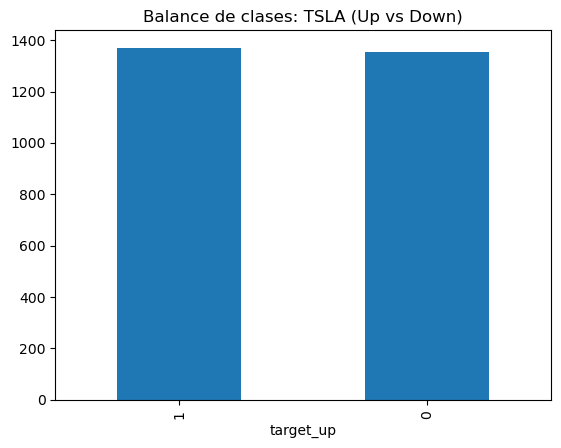

In [174]:
#Definir taget_up
df["target_up"] = (df["close"] > df["open"]).astype(int)

# Balance de clases 
class_balance = (
    df["target_up"]
    .value_counts(normalize=True)
    .rename("proportion")
)

print(class_balance)

df["target_up"].value_counts().plot(
    kind="bar",
    title="Balance de clases: TSLA (Up vs Down)"
);


## Interpretación — Balance de Clases

Al analizar la distribución de la variable objetivo binaria (`target_up`), encontramos el siguiente balance de clases para el activo TSLA:

* **Clase 1** (Día al alza): **$\sim 50.27\%$**
* **Clase 0** (Día a la baja): **$\sim 49.72\%$**

### Conclusiones Clave:

1.  **Dataset Equilibrado:** El conjunto de datos está **prácticamente equilibrado** ($\approx 50/50$).
2.  **No se Requiere Resampling:** Dada la equidad en las proporciones, **no es necesario** aplicar técnicas de remuestreo como *oversampling* (SMOTE, etc.) o *undersampling* (reducción de la clase mayoritaria).
3.  **Sesgo del Modelo:** El modelo de Machine Learning **no estará sesgado** hacia una clase predominante, lo que simplifica la evaluación del rendimiento.

Se analiza la variación intradía mediante la siguiente métrica de rendimiento (retorno):

$$
\text{return\_close\_open} = \frac{close - open}{open}
$$ (día bajista).a.

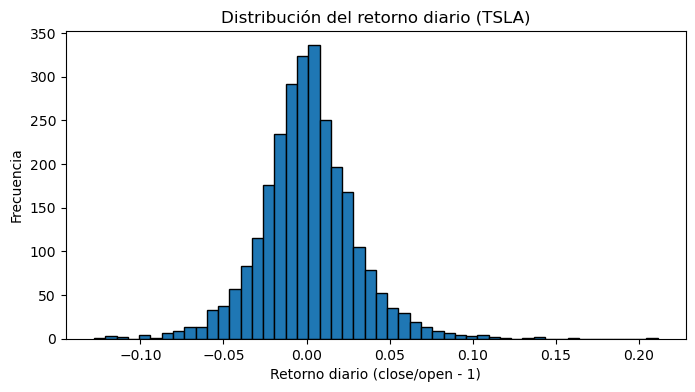

count    2725.000000
mean        0.000638
std         0.028954
min        -0.127897
25%        -0.015460
50%         0.000236
75%         0.016312
max         0.211447
Name: return_close_open, dtype: float64

In [175]:
# Distribución de retornos diarios

df["return_close_open"] = (df["close"] - df["open"]) / df["open"]

plt.figure(figsize=(8,4))
plt.hist(df["return_close_open"], bins=50, edgecolor="black")
plt.title("Distribución del retorno diario (TSLA)")
plt.xlabel("Retorno diario (close/open - 1)")
plt.ylabel("Frecuencia")
plt.show()

df["return_close_open"].describe()



## Interpretación — Distribución del Retorno Intradía (`return_close_open`)

Al analizar la distribución del retorno intradía (la variación porcentual entre el cierre y la apertura) se obtienen las siguientes métricas clave:

* **Media** $\approx +0.06\%$: Indica que, en promedio, el movimiento intradía es **ligeramente positivo** (tiende a terminar un poco por encima de donde abrió).
* **Desviación Estándar** $\approx 3\%$: Señala una **alta volatilidad**, lo cual es un comportamiento típico del activo TSLA.
* **Rango de Valores Extremos** $\approx -12.8\%$ a $+21.1\%$: Muestra que la acción experimenta movimientos extremos en ambas direcciones.
* **Mediana** $\approx 0$: Indica que la mayoría de los días presentan **movimientos netos muy pequeños** (el cierre está muy cerca de la apertura).
* **Colas Largas (Outliers):** La distribución presenta **colas largas**, confirmando la presencia de *outliers* o movimientos extremos que pueden distorsionar los resultados de modelos menos robustos.

### Conclusión

Esto confirma que los precios día a día son **ruidosos**. Los modelos simples tendrán dificultad para generar predicciones precisas si las características o ('features') de entrada no son capaces de capturar tendencias y señales reales a largo plazo, más allá del ruido diario.

In [176]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [177]:
#3. EDA breve
#Correlaciones

# Seleccionar solo columnas numéricas relevantes
numeric_cols = [
    "open","high","low","close","volume",
    "return_close_open","return_prev_close","volatility_5d",
    "target_up"
]

df_num = df[numeric_cols].copy()

#matriz de correlacion
corr_matrix = df_num.corr()
corr_matrix


open      high       low     close    volume  \
open               1.000000  0.999599  0.999497  0.998937 -0.097489   
high               0.999599  1.000000  0.999491  0.999535 -0.092101   
low                0.999497  0.999491  1.000000  0.999573 -0.102268   
close              0.998937  0.999535  0.999573  1.000000 -0.096157   
volume            -0.097489 -0.092101 -0.102268 -0.096157  1.000000   
return_close_open -0.028588 -0.010771 -0.009745  0.007764  0.055241   
return_prev_close -0.005733  0.007577  0.008758  0.022988  0.091932   
volatility_5d      0.191901  0.197027  0.186003  0.192341  0.497687   
target_up         -0.019872 -0.007721 -0.006874  0.005036  0.025423   

                   return_close_open  return_prev_close  volatility_5d  \
open                       -0.028588          -0.005733       0.191901   
high                       -0.010771           0.007577       0.197027   
low                        -0.009745           0.008758       0.186003   
close                       0.007764           0.022988       0.192341   
volume                      0.055241           0.091932       0.497687   
return_close_open           1.000000           0.783668       0.038508   
return_prev_close           0.783668           1.000000       0.078116   
volatility_5d               0.038508           0.078116       1.000000   
target_up                   0.730631           0.564894      -0.002063   

                   target_up  
open               -0.019872  
high               -0.007721  
low                -0.006874  
close               0.005036  
volume              0.025423  
return_close_open   0.730631  
return_prev_close   0.564894  
volatility_5d      -0.002063  
target_up           1.000000

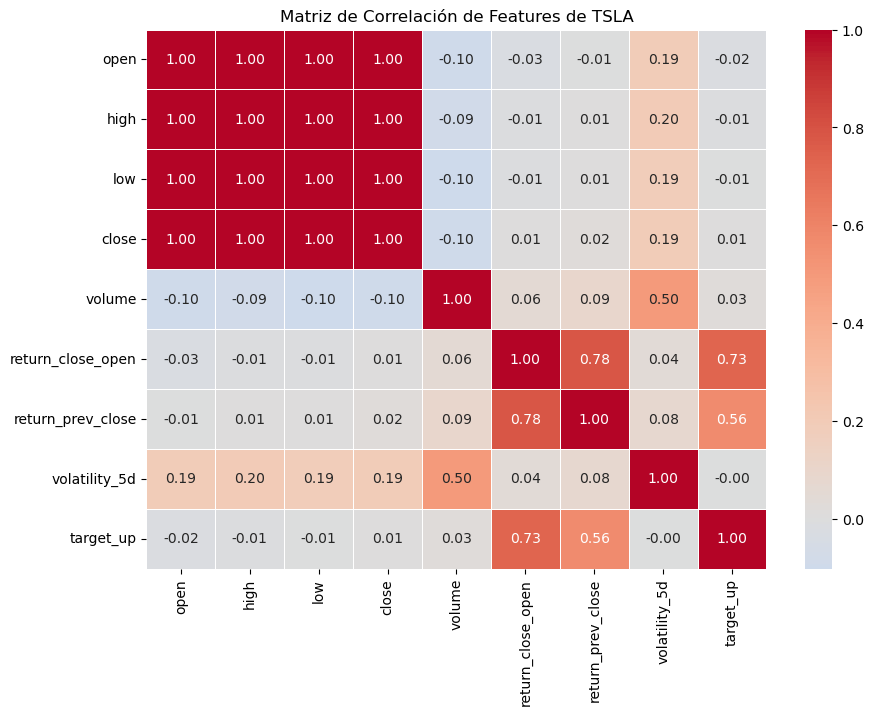

In [178]:
#heatmap de correlacion

plt.figure(figsize=(10,7))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Matriz de Correlación de Features de TSLA")
plt.show()


In [179]:
#correlacion individual contra target_up
corr_target = corr_matrix["target_up"].sort_values(ascending=False)
corr_target


target_up            1.000000
return_close_open    0.730631
return_prev_close    0.564894
volume               0.025423
close                0.005036
volatility_5d       -0.002063
low                 -0.006874
high                -0.007721
open                -0.019872
Name: target_up, dtype: float64

/tmp/ipykernel_38898/873503841.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


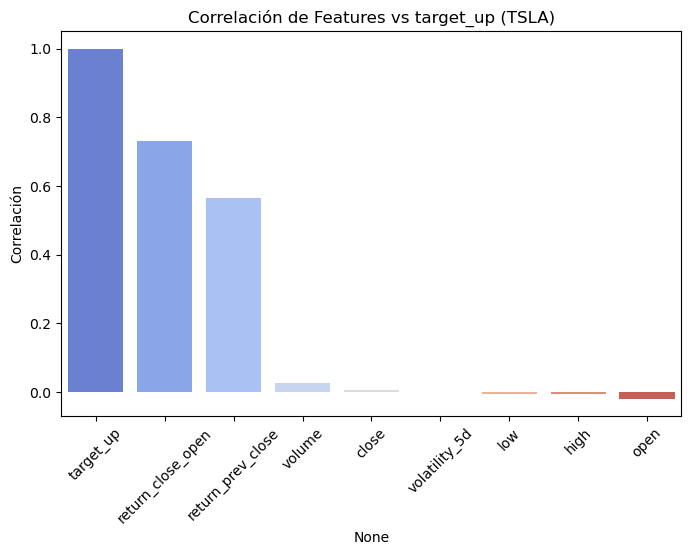

In [180]:
#Grafico de barras de correlacion con el target
plt.figure(figsize=(8,5))
sns.barplot(
    x=corr_target.index,
    y=corr_target.values,
    palette="coolwarm"
)
plt.xticks(rotation=45)
plt.title("Correlación de Features vs target_up (TSLA)")
plt.ylabel("Correlación")
plt.show()


## Interpretación de Correlaciones

A continuación, se interpretan las correlaciones encontradas entre las características del activo:

### (1) Precios OHLC altamente correlacionados

**(open, high, low, close $\approx 0.999$ entre sí)**

Esto es **totalmente esperable**; provienen de las mismas horas de *trading* del mismo día.

**Implicaciones Clave:**

* **No aportan señal predictiva directa:** Utilizar estos precios brutos no añade valor predictivo al modelo debido a su alta redundancia.
* **Necesidad de Transformaciones:** Se requiere transformarlos en métricas que sí capturen información relevante para la predicción, como:
    * **Lags:** Usar el precio de *ayer* para predecir el de *hoy*.
    * **Retornos:** Calcular la variación porcentual entre ellos.
    * **Ratios:** Crear indicadores como $\frac{close}{open}$.

### (2) Volumen correlaciona con volatilidad (0.49)

**Observación:** Los días con más volumen de negociación suelen ser días que también presentan **más movimientos fuertes** (mayor volatilidad).

Esto es un patrón **esperado** en el comportamiento de activos de alta liquidez y seguimiento como TSLA. El volumen actúa como un *proxy* (sustituto) de la actividad del mercado y la convicción de los *traders*.

## Interpretación de Correlaciones con el Target (`target_up`)

El análisis de correlación entre diversas características y la variable objetivo (`target_up`) proporciona información crítica sobre la validez de cada *feature* para el entrenamiento del modelo:

* **`return_close_open` → Correlación = $0.73$**
    * **MUY ALTA** Esto es una clara señal de **data leakage** (fuga de información).
    * **Razón:** Esta métrica contiene la misma información que el *target* (si $close > open$).
    * **Implicación:** **NO se puede usar** para el entrenamiento del modelo, ya que el modelo simplemente estaría memorizando el *target*.

* **`return_prev_close` → Correlación moderada ($0.56$)**
    * **Señal Válida:** Esta es una correlación significativa y **válida** si se usa como lag.
    * **Implicación:** Muestra que los movimientos del día anterior (`return_prev_close`) tienen una correlación moderada con la dirección del día actual (`target_up`), lo que la convierte en una característica útil.

* **Volatilidad 5D → Correlación $\approx 0$**
    * **Implicación:** La volatilidad histórica de los últimos 5 días **no predice directamente** si el precio subirá o bajará; solo predice la magnitud del movimiento (el ruido).

* **Precios Brutos (open, high, low, close) → Correlaciones bajas con el Target**
    * **Implicación:** Los precios brutos tienen poco poder predictivo por sí mismos. **Deben transformarse** en *features* derivados (como *lags*, retornos, o indicadores técnicos) para ser útiles.

## Resumen del Análisis Exploratorio de Datos (EDA)

El Análisis Exploratorio de Datos (EDA) reveló las siguientes conclusiones fundamentales para la fase de modelado:

* **Balance de Datos:** El *dataset* está **balanceado** ($\approx 50/50$), lo cual es una condición ideal para los modelos de clasificación y no requiere técnicas de remuestreo (como *oversampling* o *undersampling*).
* **Volatilidad:** Los retornos diarios son altamente **volátiles**, lo que confirma que el entorno de predicción intradía es ruidoso y, por lo tanto, inherentemente difícil.
* **Fuga de Información (*Data Leakage*):** Se han identificado *features* que no deben ser utilizados debido a *data leakage* (fuga de información), como, por ejemplo, `return_close_open`, que contiene la información del *target*.
* **Ingeniería de Características:** Los precios brutos (OHLC) tienen baja capacidad predictiva. Para ser útiles en los modelos de Machine Learning, deben transformarse en **características derivadas** como:
    * *Lags* (valores pasados).
    * Retornos.
    * Volatilidad.
    * Medias móviles.
    * Indicadores técnicos.

# **4. Features y target**

# Ingeniería de Características (Feature Engineering)

El objetivo de esta sección es construir variables que realmente puedan predecir la dirección del precio al final del día, **evitando cualquier uso indebido de información del futuro** (**data leakage**).

Para esto se aplicaron las siguientes técnicas de derivación de *features*:
* **Lags** (valores de días anteriores).
* **Ventanas móviles** (promedios, volatilidad, etc.).
* **Indicadores técnicos clásicos**.
* **Derivados estadísticos** del precio.

A continuación, se describen todos los *features* utilizados y por qué son válidos para la predicción.

## Evitar el *Data Leakage* 

Para un problema de **predicción intradía** como el que se aborda:

$$
\text{target\_up} = 1 \text{ si close > open}
$$

El modelo solo puede utilizar la información que está **disponible ANTES de la apertura del día actual ($open_t$)**. Esto es fundamental para simular una situación real de *trading*.

Por esta razón, todas las variables derivadas que provienen del día anterior o de ventanas históricas anteriores se aplican utilizando el método `.shift(1)` en *pandas*.

**Garantía:** Esto asegura que el modelo no tenga acceso a ninguna información no disponible al comienzo del día de la operación.

In [181]:
import numpy as np

In [182]:
# crear lags
df = df.sort_values("date").reset_index(drop=True)

df["return_prev_close_lag1"] = df["return_prev_close"].shift(1)
df["return_prev_close_lag2"] = df["return_prev_close"].shift(2)

df["return_close_open_lag1"] = df["return_close_open"].shift(1)

df["volume_lag1"] = df["volume"].shift(1)
df["volume_lag2"] = df["volume"].shift(2)

df["volume_ma5"] = df["volume"].rolling(5).mean()
df["volume_ma5_lag1"] = df["volume_ma5"].shift(1)


df["volatility_5d_lag1"] = df["volatility_5d"].shift(1)
df["volatility_5d_lag2"] = df["volatility_5d"].shift(2)

df["range_lag1"] = ((df["high"] - df["low"]) / df["open"]).shift(1)

df["high_lag1"] = df["high"].shift(1)
df["low_lag1"] = df["low"].shift(1)

#SMA y EMA (medias moviles)
df["sma_5"] = df["close"].rolling(5).mean().shift(1)
df["ema_5"] = df["close"].ewm(span=5, adjust=False).mean().shift(1)


#RSI (relative strenght index)
delta = df["close"].diff()

gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

roll_up = gain.rolling(14).mean()
roll_down = loss.rolling(14).mean()

rs = roll_up / roll_down
df["rsi_14"] = (100 - (100 / (1 + rs))).shift(1)

#MACD (Moving average convergence divergence
ema12 = df["close"].ewm(span=12, adjust=False).mean()
ema26 = df["close"].ewm(span=26, adjust=False).mean()

df["macd"] = (ema12 - ema26).shift(1)
df["macd_signal"] = df["macd"].ewm(span=9, adjust=False).mean().shift(1)

#Momentum (log returns acumulados)
df["log_return"] = np.log(df["close"] / df["close"].shift(1))
df["momentum_5"] = df["log_return"].rolling(5).sum().shift(1)

#Bandas de Bollinger
rolling_mean = df["close"].rolling(20).mean()
rolling_std = df["close"].rolling(20).std()
df["boll_up"] = (rolling_mean + 2 * rolling_std).shift(1)
df["boll_down"] = (rolling_mean - 2 * rolling_std).shift(1)
# Price position dentro de las bandas (mejor feature)
df["boll_position"] = ((df["close"] - rolling_mean) / (2 * rolling_std)).shift(1)

#Volumen relativo
df["volume_rel"] = df["volume"] / df["volume_ma5"]
df["volume_rel"] = df["volume_rel"].shift(1)

#DISTANCIA A MÁXIMO / MÍNIMO DE N DÍAS
df["dist_max_5"] = (df["close"] - df["close"].rolling(5).max()) / df["close"].rolling(5).max()
df["dist_min_5"] = (df["close"] - df["close"].rolling(5).min()) / df["close"].rolling(5).min()

df["dist_max_5"] = df["dist_max_5"].shift(1)
df["dist_min_5"] = df["dist_min_5"].shift(1)

df = df.dropna().reset_index(drop=True)


## Descripción Detallada de los Features Utilizados

### A. Precio y Rangos del Día Anterior

| Feature | Significado e Implicaciones |
| :--- | :--- |
| **`high_lag1`, `low_lag1`** | Máximos y mínimos del día anterior. Representan el rango e intensidad del movimiento previo. **No generan leakage** porque se desplazan 1 día. |
| **`range_lag1`** | Mide la amplitud relativa del rango del día anterior: $\frac{high - low}{open}$ (desplazada con `.shift(1)`).  **Rango amplio** = mercado activo → mayor probabilidad de continuación. **Rango pequeño** = consolidación → señales débiles. |

### B. Volumen

| Feature | Significado | Motivación y Uso |
| :--- | :--- | :--- |
| **`volume`** | Volumen del día (dato intradía, permitido por el proyecto). | Volumen creciente generalmente acompaña tendencias; volumen bajo genera señales de baja confianza. |
| **`volume_lag1`, `volume_lag2`** | Tendencia del volumen en días previos. | |
| **`volume_ma5_lag1`** | Media móvil simple del volumen (5 días). | Estabilidad o presión de demanda. |
| **`volume_rel`** | Volumen normalizado respecto al promedio histórico. | Detección de eventos inusuales. |

### C. Retornos y Momentum Simple

| Feature | Interpretación | Justificación |
| :--- | :--- | :--- |
| **`return_prev_close_lag1`, `lag2`** | Inercia del movimiento reciente. | Los retornos recientes muestran la fuerza del movimiento. |
| **`return_close_open_lag1`** | Momentum intradía del día anterior. | Algunos mercados tienen tendencia a la continuidad (overreaction) o reversión (mean reversion). |

### D. Volatilidad

| Feature | Significado e Implicaciones |
| :--- | :--- |
| **`volatility_5d_lag1`, `lag2`** | Desviación estándar de retornos recientes (ventana de 5 días). **Alta volatilidad** puede indicar rompimientos y mayor probabilidad de reversión. **Baja volatilidad** se asocia con consolidación. |

### E. Indicadores de Tendencia (SMA y EMA)

| Feature | Descripción |
| :--- | :--- |
| **`sma_5`** | Promedio móvil simple (5 días). |
| **`ema_5`** | Promedio móvil exponencial (5 días). |
| ** Uso:** Capturan la tendencia de corto plazo. La EMA reacciona más rápido y se utiliza para medir el *momentum* inmediato. |

### F. Momentum Avanzado

| Feature | Descripción e Impacto |
| :--- | :--- |
| **`momentum_5`** | Suma de retornos logarítmicos de los últimos 5 días.  **Detecta aceleración o desaceleración del precio.** Fundamental en modelos de *trend following* (seguimiento de tendencia). |

### G. RSI (14 días)

| Feature | Descripción e Implicaciones |
| :--- | :--- |
| **`rsi_14`** | Mide la presión compradora vs. vendedora. **RSI alto** → posible sobrecompra. **RSI bajo** → posible sobreventa. |
| **Uso:** Señal clásica del análisis técnico para identificar condiciones extremas. | 

### H. MACD (Convergencia/Divergencia de Medias Móviles)

| Feature | Significado |
| :--- | :--- |
| **`macd`** | EMA12 $\mathbf{-}$ EMA26 (Línea rápida). |
| **`macd_signal`** | EMA de 9 períodos del MACD (Línea lenta). |
| **Uso:** MACD captura **cambios de tendencia**, **divergencias** y **momentum intermedio**. | 

### I. Bandas de Bollinger

| Feature | Descripción e Interpretación |
| :--- | :--- |
| **`boll_position`** | Precio normalizado dentro de las bandas (distancia al centro dividida por la desviación estándar). |
| **Interpretación:** Valores positivos $\rightarrow$ precio cerca de banda superior $\Rightarrow$ presión alcista. Valores negativos $\rightarrow$ precio en banda inferior $\Rightarrow$ presión bajista. |
| **Impacto:** Uno de los *features* con mayor potencia predictiva en modelos ML. |

### J. Distancia a Máximos/Mínimos Recientes

| Feature | Descripción e Interpretación |
| :--- | :--- |
| **`dist_max_5`** | Qué tan lejos está el precio del máximo reciente (5 días). |
| **`dist_min_5`** | Qué tan lejos está del mínimo reciente (5 días). |
| **Interpretación:** Cerca del máximo $\rightarrow$ *breakout* potencial. Cerca del mínimo $\rightarrow$ riesgo de *breakdown* (ruptura a la baja). |

### K. Variables Categóricas

| Feature | Por qué es útil |
| :--- | :--- |
| **`day_of_week`** | Captura patrones semanales (ej., lunes alcista, viernes de ventas). |
| **`month`** | Captura efectos estacionales (ej., "efecto enero", septiembre débil). |
| ** Proceso:** Se codifican con `OneHotEncoder` para ser utilizadas por los modelos. |

In [183]:
#seleccion final de features

feature_cols = [

    # --- Precio y rangos ---
    "open",
    "high_lag1", "low_lag1",
    "range_lag1",

    # --- Volumen ---
    "volume",
    "volume_lag1", "volume_lag2",
    "volume_ma5_lag1",
    "volume_rel",

    # --- Retornos y momentum simple ---
    "return_prev_close_lag1",
    "return_prev_close_lag2",
    "return_close_open_lag1",

    # --- Volatilidad ---
    "volatility_5d_lag1",
    "volatility_5d_lag2",

    # --- Tendencias (SMA / EMA) ---
    "sma_5",
    "ema_5",

    # --- Momentum avanzado ---
    "momentum_5",

    # --- RSI ---
    "rsi_14",

    # --- MACD ---
    "macd",
    "macd_signal",

    # --- Bandas de Bollinger ---
    "boll_position",

    # --- Distancia a máximos/mínimos recientes ---
    "dist_max_5",
    "dist_min_5",

    # --- Categóricas ---
    "day_of_week",
    "month"
]


X = df[feature_cols].dropna()
y = df.loc[X.index, "target_up"]


## Justificación Final del Feature Engineering

El proceso de Ingeniería de Características garantiza una base de datos robusta y válida para el modelado:

1.  **Evitar *Data Leakage***: Todos los *features* se construyen utilizando **lags** o **ventanas temporales anteriores** (por ejemplo, con `.shift(1)`), lo que previene la filtración de información futura al momento de la predicción.

2.  **Combinación de Componentes Clave:** Se combinan características de diversas áreas para capturar la mayor cantidad de dinámica del mercado posible:
    * **Tendencias** (Medias Móviles).
    * **Momentum** (RSI, MACD, Retornos).
    * **Volatilidad** (Desviación Estándar).
    * **Presión Compradora/Vendedora** (Volumen, Bandas de Bollinger).
    * **Señales Estacionales** (Día de la Semana, Mes).

El objetivo estratégico es permitir que tanto modelos **lineales** como **no lineales** capturen patrones robustos en los datos, donde un único indicador sería insuficiente y débil para generar una señal operable.

# **5. Split temporal (Train / Val / Test)**

## Validación Temporal: La Importancia del Split Cronológico

En los problemas de series de tiempo y, particularmente, en los **problemas financieros**, **no se puede utilizar un *split* aleatorio** (como el *k-fold cross-validation* estándar).

Hacer un *split* aleatorio provoca **data leakage temporal**:

* El modelo podría ver **información del futuro** (ej., precios de 2024 en el set de entrenamiento) para predecir el pasado (ej., precios de 2020 en el set de validación).

Por esta razón, se utiliza un **split estrictamente cronológico**, respetando la secuencia del tiempo, asegurando que el conjunto de entrenamiento siempre preceda temporalmente al conjunto de validación y prueba.

## Criterio del Split Cronológico

Se dividió el *dataset* utilizando un **split estrictamente cronológico** basado en años completos. Este enfoque garantiza que no haya *data leakage* temporal y simula el escenario de aplicación en la vida real.

| Conjunto | Período | Justificación y Uso |
| :--- | :--- | :--- |
| **Train** | **2015 - 2021** | Contiene suficientes años de datos históricos para que el modelo aprenda los patrones del activo. |
| **Validation** | **2022 – 2024** | Se usa exclusivamente para el *tuning* y optimización de hiperparámetros y para la selección del mejor modelo, sin tocar los datos futuros. |
| **Test** | **Desde 1-ene-2025** | Se reserva **estrictamente** para la evaluación final fuera de muestra y la simulación de *trading*, como exige el proyecto. |

Este enfoque asegura que:

* El modelo **solo ve pasado** durante la fase de entrenamiento.
* El conjunto de Validación simula **"años recientes no vistos"** para seleccionar el mejor modelo.
* 2025 se reserva como un **escenario de prueba real**, permitiendo una evaluación imparcial del rendimiento operativo.

In [184]:
dates = df["date"]

In [185]:
#creacion de los conjuntos de train, validacion, y test

# Asegurar que está ordenado por fecha
df = df.sort_values("date").reset_index(drop=True)

# Fechas del split
train_end = "2021-12-31"
val_end = "2024-12-31"


# Máscara booleana para cada parte
train_mask = (df["date"] <= train_end)
val_mask = (df["date"] > train_end) & (df["date"] <= val_end)
test_mask = (df["date"] > val_end)

# Aplicar las máscaras
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print("Tamaños:")
print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print("Test:", X_test.shape)


Tamaños:
Train: (1743, 25)
Validation: (753, 25)
Test: (209, 25)


In [186]:
#confirmación de que la separación respeta el tiempo
print(df.loc[train_mask, "date"].min(), df.loc[train_mask, "date"].max())
print(df.loc[val_mask, "date"].min(), df.loc[val_mask, "date"].max())
print(df.loc[test_mask, "date"].min(), df.loc[test_mask, "date"].max())


2015-02-02 00:00:00 2021-12-31 00:00:00
2022-01-03 00:00:00 2024-12-31 00:00:00
2025-01-02 00:00:00 2025-10-31 00:00:00


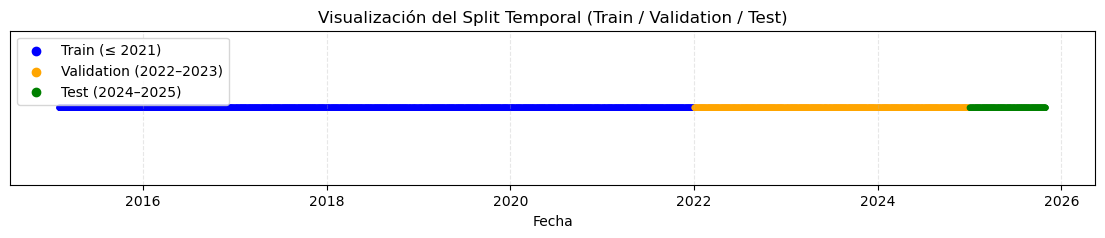

In [187]:
#visualizacion del split temporal
# Crear vector de fechas
dates = df["date"]

# Crear arreglo de colores
colors = np.where(train_mask, "blue",
                  np.where(val_mask, "orange", "green"))

plt.figure(figsize=(14, 2))
plt.scatter(dates, np.zeros_like(dates), c=colors, s=12)

plt.yticks([])
plt.xlabel("Fecha")
plt.title("Visualización del Split Temporal (Train / Validation / Test)")
plt.grid(axis="x", linestyle="--", alpha=0.3)

# Leyenda manual
plt.scatter([], [], color="blue", label="Train (≤ 2021)")
plt.scatter([], [], color="orange", label="Validation (2022–2023)")
plt.scatter([], [], color="green", label="Test (2024–2025)")

plt.legend(loc="upper left")
plt.show()

# **6. Preprocesamiento**

## Preprocesamiento de Datos (Pipeline)

Los modelos de Machine Learning utilizados en este proyecto requieren que los datos sean transformados de manera sistemática y consistente antes del entrenamiento.

En particular, se aplicaron las siguientes transformaciones dentro del *pipeline* de preprocesamiento:

* **Imputación de valores nulos:** Rellenar o gestionar los valores faltantes (NaN) en los *features*.
* **Escalado (`StandardScaler`):** Aplicado a las variables numéricas para estandarizar su distribución ($\mu=0, \sigma=1$). Este paso es **crucial** para el buen rendimiento de los modelos lineales y los basados en distancia.
* **One-Hot Encoding:** Aplicado a las variables categóricas (`day_of_week`, `month`) para convertirlas en un formato binario que los modelos puedan interpretar. 

### Estrategia de Implementación

Todas estas transformaciones se integraron dentro de un **Pipeline** combinado con un **ColumnTransformer**.

**Ventajas:**

* **Consistencia:** Esto garantiza la **consistencia** absoluta en las transformaciones aplicadas entre las fases de entrenamiento, validación, *test* y, finalmente, el despliegue del modelo en la API de producción.
* **Despliegue Simple:** El *pipeline* completo (transformaciones + modelo) se guarda y se despliega como una única unidad.

In [188]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

## Preprocesamiento Numérico

Para las características numéricas (la mayoría de los *features* financieros), se aplicaron los siguientes pasos de preprocesamiento:

### 1. Imputación de Valores Nulos

* **Método:** Imputación con la **Mediana**.
* **Justificación:** La mediana es **robusta a *outliers*** (valores extremos), que son frecuentes en los datos financieros. Usar la media podría sesgar la imputación de manera significativa.

### 2. Escalado

* **Método:** Uso de **`StandardScaler`**.
* **Justificación:**
    * Muchos modelos (como Regresión Logística, y modelos de *Gradient Boosting*) son **sensibles a la escala** de los datos.
    * El escalado evita que características con magnitudes grandes dominen el entrenamiento sobre aquellas que tienen magnitudes pequeñas, asegurando que todos los *features* contribuyan equitativamente a la función de costo.

In [189]:
num_features = [
    "open",
    "high_lag1", "low_lag1",
    "range_lag1",
    
    "volume",
    "volume_lag1", "volume_lag2",
    "volume_ma5_lag1",
    "volume_rel",

    "return_prev_close_lag1",
    "return_prev_close_lag2",
    "return_close_open_lag1",

    "volatility_5d_lag1",
    "volatility_5d_lag2",

    "sma_5",
    "ema_5",

    "momentum_5",

    "rsi_14",

    "macd",
    "macd_signal",

    "boll_position",

    "dist_max_5",
    "dist_min_5",
]

#Pipeline de transformación

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])


## Preprocesamiento Categórico

Para las características categóricas (`day_of_week` y `month`), se aplicaron los siguientes pasos de preprocesamiento:

### 1. Imputación

* **Método:** Imputación del **valor más frecuente** (*Most Frequent*).
* **Justificación:** Si bien estas variables (día de la semana, mes) no suelen contener valores nulos en series de tiempo financieras bien estructuradas, se incluye este respaldo para la robustez del *pipeline*.

### 2. Codificación

* **Método:** **One-Hot Encoding**. 
* **Justificación:** Convierte las variables categóricas nominales (`day_of_week`, `month`) en un conjunto de **variables binarias (0 o 1)**. Esto permite que el modelo capture los patrones semanales y estacionales asociados con días específicos de la semana o meses específicos (ej., el "efecto lunes" o el "efecto enero").

In [190]:
cat_features = ["day_of_week", "month"]

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])


## Ensamblaje del Preprocesamiento con `ColumnTransformer`

Todo el proceso de preprocesamiento se consolida y automatiza mediante el uso de la clase **`ColumnTransformer`** de `scikit-learn`.

El `ColumnTransformer` permite aplicar **automáticamente** las transformaciones adecuadas (como `StandardScaler` o `OneHotEncoder`) a cada subconjunto de columnas (numéricas o categóricas) dentro del *pipeline* general.

In [191]:
# ColumnTransformer 

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['open', 'high_lag1', 'low_lag1', 'range_lag1',
                                  'volume', 'volume_lag1', 'volume_lag2',
                                  'volume_ma5_lag1', 'volume_rel',
                                  'return_prev_close_lag1',
                                  'return_prev_close_lag2',
                                  'return_close_open_lag1',
                                  'volatility_5d_lag1', 'volatility_5d_lag2',
                                  'sma_5', 'ema_5', 'momentum_5', 'rsi_14',
                                  'macd', 'macd_signal', 'boll_position',
                                  'dist_max_5', 'dist_min_5']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['day_of_week', 'month'])])

# **7. Modelado**

**7.0 Baseline**

El baseline predice siempre la clase mayoritaria.

En el dataset:

target_up

* 1    50.27%

* 0    49.72%


Eso significa que está equilibrado, pero la clase mayoritaria es 1 (sube).

Por lo tanto, el baseline predice siempre:

target_up = 1

Es decir, se construyó un modelo baseline trivial que predice siempre la clase mayoritaria (target_up = 1).
Este baseline representa el rendimiento mínimo que cualquier modelo debe superar para ser útil en trading.

In [192]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

In [193]:
# Baseline: siempre predecir la clase mayoritaria
majority_class = y_train.mode()[0]
print("Clase mayoritaria:", majority_class)

# Predicciones triviales
y_train_pred = np.full_like(y_train, majority_class)
y_val_pred = np.full_like(y_val, majority_class)

def evaluate_baseline(y_true, y_pred, split_name):
    print(f"\nMétricas Baseline – {split_name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1:", f1_score(y_true, y_pred))
    
    # ROC-AUC necesita probabilidades, pero para baseline usamos:
    try:
        print("ROC-AUC:", roc_auc_score(y_true, y_pred))
    except:
        print("ROC-AUC: No válido (solo una clase predicha)")

# Evaluar en cada split
evaluate_baseline(y_train, y_train_pred, "Train")
evaluate_baseline(y_val, y_val_pred, "Validation")


Clase mayoritaria: 1

Métricas Baseline – Train
Accuracy: 0.5060240963855421
Precision: 0.5060240963855421
Recall: 1.0
F1: 0.6719999999999999
ROC-AUC: 0.5

Métricas Baseline – Validation
Accuracy: 0.4953519256308101
Precision: 0.4953519256308101
Recall: 1.0
F1: 0.6625222024866785
ROC-AUC: 0.5


In [194]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metricas_modelos_validation = [] #aqui se guardaran las metricas de todos los modelos obtenidas en el conjunto de validacion 
metricas_modelos_train = []

#funcion para registrar metricas
def evaluar_modelo(nombre, model, X_val, y_val, metricas):

    # -- Predicciones --
    y_pred = model.predict(X_val)

    # -- Scores continuos (para ROC-AUC) --
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_val)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_val)
    else:
        y_score = None

    # -- Métricas --
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_score) if y_score is not None else None

    # -- Guardar en la lista --
    metricas.append({
        "modelo": nombre,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc
    })

    print(f"Modelo evaluado: {nombre}")


In [195]:
#evaluar en validation y en test 

def evaluate_model(model, X, y, name="Set"):
    print(f"\n Resultados en {name}")

    # Predicciones discretas
    y_pred = model.predict(X)

    # Intentar obtener probabilidades o scores
    y_score = None
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X)

    # Métricas
    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # ROC-AUC solo si hay score continuo
    if y_score is not None:
        auc = roc_auc_score(y, y_score)
        print(f"ROC-AUC:   {auc:.4f}")
    else:
        print("ROC-AUC:   No disponible (modelo no soporta scores continuos)")

    print("Matriz de confusión:")
    print(confusion_matrix(y, y_pred))

Para abordar el problema de clasificación de movimientos diarios del activo TSLA, se entrenaron y compararon múltiples modelos de *machine learning* pertenecientes a diferentes familias, con el objetivo de evaluar distintos supuestos inductivos y capacidades de generalización.

### Modelos Entrenados

Se entrenaron al menos siete modelos distintos, cubriendo las siguientes categorías:

* **Modelos Lineales**
    * Regresión Logística
    * Linear Support Vector Classifier (LinearSVC)
* **Árboles de Decisión**
    * Decision Tree Classifier
* **Modelos de Ensamble**
    * Random Forest
* **Modelos de *Boosting***
    * Gradient Boosting Classifier
    * LightGBM
    * Catboost Classifier

Cada modelo fue integrado dentro de un **Pipeline de scikit-learn**, que incluye:

* Preprocesamiento (imputación, escalado y *encoding*)
* Modelo final de clasificación

Esto garantiza que todo el flujo sea consistente y **libre de *data leakage***. 

### Ajuste de Hiperparámetros con GridSearchCV

Para mejorar el rendimiento de los modelos y evitar configuraciones arbitrarias, se utilizó `GridSearchCV` para el ajuste sistemático de hiperparámetros.

#### Metodología de *Tuning*

Se definieron *grids* específicos por modelo, priorizando:

* **Regularización** ($C$, *penalty*)
* **Complejidad** del modelo (profundidad, número de árboles)
* Parámetros críticos de convergencia

Se utilizó **validación temporal**, respetando el orden cronológico de los datos. Además, para cada modelo se intentó hacer al menos dos gridSearch para tunear mejor los hiperparámetros.

#### Métrica Principal de Optimización

La métrica principal de optimización fue **F1 Score**, ya que:

* El problema es binario.
* Se busca **balance entre *precision* y *recall***.
* Es más informativa que *accuracy* en *trading*.


**7.1 Regresion Logistica**

In [196]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import joblib

In [197]:
# Crear la pipeline con Logistic Regression
# utilizamos el mismo preprocesador que se habia definido anteriormente

pipeline_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=500))
])


In [198]:
#definir el grid de hiperparametros
param_grid_lr_1 = {

    # Regularización inversa (controla el sobreajuste)
    "clf__C": [
        0.0001, 0.001, 0.01, 
        0.1, 1, 10, 100
    ],

    # Penalización solo L2 (la única estable con series de tiempo)
    "clf__penalty": ["l2"],

    # Solvers recomendados para L2
    "clf__solver": ["lbfgs", "liblinear", "saga"],

    # Activar o no el balanceo (ayuda muchísimo en targets desbalanceados)
    "clf__class_weight": [None, "balanced"],

    # Tolerancia: afecta convergencia y precisión
    "clf__tol": [1e-3, 1e-4, 1e-5],

    # Iteraciones por si el modelo necesita más para converger
    "clf__max_iter": [200, 500, 1000],
}



In [199]:
#usar TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [200]:
#ejecutar gridSearch
grid_lr_1 = GridSearchCV(
    pipeline_lr,
    param_grid_lr_1,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

grid_lr_1.fit(X_train, y_train)


Fitting 5 folds for each of 378 candidates, totalling 1890 fits
[CV] END clf__C=0.0001, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.3s
[CV] END clf__C=0.0001, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.0001, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=0.0001, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.0001, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=0.0001, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.0001, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.0s
[CV] END c

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.3s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.0s
[CV] END clf__C=0.1, cl

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=bal

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=0.1, clf_

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.1s
[CV] EN

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=0.1, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.3s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weigh

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   0.3s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=Non

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STO

[CV] END clf__C=1, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=1, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   0.3s
[CV] END clf__C=

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.2s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.3s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=None, clf_

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.3s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.3s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.6s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.8s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, 

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   0.5s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   0.6s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   0.7s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=10, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.001; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=balanced, clf__ma

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_la...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__max_iter': [200, 500, 1000],
                         'clf__penalty': ['l2'],
                         'clf__solver': ['lbfgs', 'liblinear', 'saga'],
                         'clf__tol': [0.001, 0.0001, 1e-05]},
             scoring='f1', verbose=2)

In [201]:
print("Mejores hiperparámetros:", grid_lr_1.best_params_)

Mejores hiperparámetros: {'clf__C': 100, 'clf__class_weight': 'balanced', 'clf__max_iter': 500, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'clf__tol': 0.001}


In [202]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [203]:
#mejor modelo
best_lr = grid_lr_1.best_estimator_

In [204]:
evaluate_model(best_lr, X_train, y_train, "Train")
evaluate_model(best_lr, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  0.5496
Precision: 0.5574
Recall:    0.5340
F1 Score:  0.5455
ROC-AUC:   0.5789
Matriz de confusión:
[[487 374]
 [411 471]]

 Resultados en Validation
Accuracy:  0.5392
Precision: 0.5288
Recall:    0.6408
F1 Score:  0.5794
ROC-AUC:   0.5368
Matriz de confusión:
[[167 213]
 [134 239]]


In [205]:
#mejora del grid de hiperparametros en base a los resultados del primer gridSearch

param_grid_lr_2 = {
    # C: Aumentamos el rango superior por si el valor óptimo es aún mayor.
    "clf__C": [100, 200, 500, 1000, 2000],

    "clf__penalty": ["l2"],
    
    # Solvers: Mantenemos, pero el problema es de 'lbfgs'.
    "clf__solver": ["liblinear", "lbfgs", "saga"], 
    
    "clf__class_weight": ["balanced"],

    # tol: Lo mantenemos en el rango estrecho y estricto.
    "clf__tol": [1e-4, 1e-5, 1e-6], 

    # ¡CLAVE! Aumentamos el límite superior para resolver el error de convergencia.
    "clf__max_iter": [500, 1000, 2000, 5000], 
}

In [206]:
#ejecutar gridSearch 2
grid_lr_2 = GridSearchCV(
    pipeline_lr,
    param_grid_lr_2,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

grid_lr_2.fit(X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   1.6s
[CV] END clf__C=10, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=10, clf__class_weigh

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.3s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.4s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.3s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.6s
[CV] END clf__C=10, clf__class_weight=None, clf__max_iter=1000

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=100, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.7s
[CV] END clf__C=100, clf__class_weight=None, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   1.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.3s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=100, clf__class_

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   0.7s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   1.0s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-06; total time=   0.1s
[CV] EN

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.6s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.8s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   1.5s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-06; total time=   0.3s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   0.6s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   1.3s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=100, 

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.3s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.6s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.6s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.4s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=200, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.3s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.001; total time=   0.2s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=100, 

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=1e-06; total time=   0.9s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   0.7s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   1.0s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=1

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=200, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=200, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=200, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=200, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=200, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=200, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=200, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.1s
[CV

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.3s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   0.6s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   1.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.2s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   1.0s
[CV] END clf__C=100, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=10

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=200, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=200, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-06; total time=   0.2s
[CV] END clf__C=200, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=200, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=200, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=200, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=200, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=2

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-06; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=500, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   0.2s
[CV] END c

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-06; total time=   1.3s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-06; total time=   

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_la...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1,
             param_grid={'clf__C': [100, 200, 500, 1000, 2000],
                         'clf__class_weight': ['balanced'],
                         'clf__max_iter': [500, 1000, 2000, 5000],
                         'clf__penalty': ['l2'],
                         'clf__solver': ['liblinear', 'lbfgs', 'saga'],
                         'clf__tol': [0.0001, 1e-05, 1e-06]},
             scoring='f1', verbose=2)

In [207]:
print("Mejores hiperparámetros gridSearch 2:", grid_lr_2.best_params_)

Mejores hiperparámetros gridSearch 2: {'clf__C': 2000, 'clf__class_weight': 'balanced', 'clf__max_iter': 500, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'clf__tol': 0.0001}


In [208]:
lr2 = grid_lr_2.best_estimator_

In [209]:
evaluate_model(lr2, X_train, y_train, "Train")
evaluate_model(lr2, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  0.5519
Precision: 0.5599
Recall:    0.5351
F1 Score:  0.5472
ROC-AUC:   0.5793
Matriz de confusión:
[[490 371]
 [410 472]]

 Resultados en Validation
Accuracy:  0.5378
Precision: 0.5275
Recall:    0.6434
F1 Score:  0.5797
ROC-AUC:   0.5363
Matriz de confusión:
[[165 215]
 [133 240]]


In [210]:
#hasta ahora lr2 es el mejor lr1
best_lr = lr2

In [211]:
#mejora de hiperparametros en base al segundo gridSearch

param_grid_lr_3 = {

    # C: Mantenemos el rango superior para confirmar si el óptimo es > 2000
    "clf__C": [
        1000, 2000, 4000, 8000, 10000 
    ],

    "clf__penalty": ["l2"],

    # Reintroducimos los otros solvers para estabilidad
    "clf__solver": ["lbfgs", "liblinear", "saga"], 
    
    "clf__class_weight": ["balanced"],

    # Tolerancia: Mantenemos el rango fino
    "clf__tol": [1e-5, 5e-5, 1e-4, 5e-4, 1e-3],

    # ¡INCREMENTO RADICAL! Para forzar la convergencia de lbfgs
    "clf__max_iter": [5000, 10000, 20000],
}

In [212]:
#ejecutar gridSearch
grid_lr_3 = GridSearchCV(
    pipeline_lr,
    param_grid_lr_3,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

grid_lr_3.fit(X_train, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.3s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-06; total time=   0.2s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.3s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   1.4s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, cl

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   8.5s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-06; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total time=   0.4s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-06; total time=   0.6s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   1.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-06; total time=   0.9s
[CV] END 

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-06; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=1000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-05; total ti

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   1.9s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-06; total time=   2.4s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   3.1s
[CV] END clf__C=500, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-06; total time=   4.5s
[CV] END clf__C=1000,

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   1.6s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   2.8s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0005; total time=   0.8s
[CV

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.001; total time=   0.2s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   7.4s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   2.9s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0005; total time=   0.7s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0005; total time=   1.4s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.3s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.6s
[CV] END clf

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=5e-05; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=5e-05; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0005; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0005; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.2s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.1s

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0005; total time=   0.1s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   3.6s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=saga, clf__tol=5e-05; total time=   9.7s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.2s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.4s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=saga, clf__tol=0.001; total time=   0.9s
[

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0005; total time=   0.1s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=  11.2s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0005; total time=   0.4s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0005; total ti

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=5e-05; total time=   0.2s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0005; total time=   0.1s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0005; total time=   0.2s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=5e-05; total time=   0.2

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=1e-06; total time=   0.2s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   0.7s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=2000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   3.7s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   1.5s
[CV] END clf__C=2000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   7.6s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=5e-05; total time=   0.1s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=5e-05; total time=   0.2s
[CV] END clf__C=1

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END clf__C=4000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=5e-05; total time=   0.3s
[CV] END clf__C=4000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=4000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0001; total time=   0.3s
[CV] END clf__C=4000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0005; total time=   0.4s
[CV] END clf__C=4000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.4s
[CV] END clf__C=4000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=liblinear, clf__tol=5e-05; total time=   0.2s
[CV] END clf__C=4000, clf__class_weight=balanced, clf__max_iter=10000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=  

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV] END clf__C=4000, clf__class_weight=balanced, clf__max_iter=20000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0005; total time=   0.1s
[CV] END clf__C=4000, clf__class_weight=balanced, clf__max_iter=20000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.0005; total time=   0.2s
[CV] END clf__C=4000, clf__class_weight=balanced, clf__max_iter=20000, clf__penalty=l2, clf__solver=lbfgs, clf__tol=0.001; total time=   0.3s
[CV] END clf__C=4000, clf__class_weight=balanced, clf__max_iter=20000, clf__penalty=l2, clf__solver=liblinear, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=4000, clf__class_weight=balanced, clf__max_iter=20000, clf__penalty=l2, clf__solver=liblinear, clf__tol=5e-05; total time=   0.1s
[CV] END clf__C=4000, clf__class_weight=balanced, clf__max_iter=20000, clf__penalty=l2, clf__solver=liblinear, clf__tol=5e-05; total time=   0.3s
[CV] END clf__C=4000, clf__class_weight=balanced, clf__max_iter=20000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0005; total 

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_la...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf',
                                        LogisticRegression(max_iter=500))]),
             n_jobs=-1,
             param_grid={'clf__C': [1000, 2000, 4000, 8000, 10000],
                         'clf__class_weight': ['balanced'],
                         'clf__max_iter': [5000, 10000, 20000],
                         'clf__penalty': ['l2'],
                         'clf__solver': ['lbfgs', 'liblinear', 'saga'],
                         'clf__tol': [1e-05, 5e-05, 0.0001, 0.0005, 0.001]},
             scoring='f1', verbose=2)

In [213]:
print("Mejores hiperparámetros:", grid_lr_3.best_params_)

Mejores hiperparámetros: {'clf__C': 2000, 'clf__class_weight': 'balanced', 'clf__max_iter': 5000, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'clf__tol': 1e-05}


In [214]:
lr3 = grid_lr_3.best_estimator_

In [215]:
evaluate_model(lr3, X_train, y_train, "Train")
evaluate_model(lr3, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  0.5525
Precision: 0.5604
Recall:    0.5363
F1 Score:  0.5481
ROC-AUC:   0.5796
Matriz de confusión:
[[490 371]
 [409 473]]

 Resultados en Validation
Accuracy:  0.5378
Precision: 0.5274
Recall:    0.6461
F1 Score:  0.5807
ROC-AUC:   0.5369
Matriz de confusión:
[[164 216]
 [132 241]]


In [216]:
#lr3 se volvio el mejor modelo 
best_lr = lr3

In [217]:
#guardar metricas en metricas_modelos_validation[]
evaluar_modelo( 
    nombre="Logistic Regression",
    model=best_lr,
    X_val=X_val,
    y_val=y_val,
    metricas=metricas_modelos_validation
)


Modelo evaluado: Logistic Regression


In [218]:
metricas_modelos_validation #confirmamos que se hayan guardado las metricas del modelo de regresion lineal en metricas_modelos_validation

[{'modelo': 'Logistic Regression',
  'accuracy': 0.5378486055776892,
  'precision': 0.5273522975929978,
  'recall': 0.646112600536193,
  'f1': 0.5807228915662651,
  'roc_auc': 0.5368985466346832}]

In [219]:
#guardar metricas en metricas_modelos_train[]
evaluar_modelo( 
    nombre="Logistic Regression",
    model=best_lr,
    X_val=X_train,
    y_val=y_train,
    metricas=metricas_modelos_train
)

Modelo evaluado: Logistic Regression


In [220]:
metricas_modelos_train

[{'modelo': 'Logistic Regression',
  'accuracy': 0.5524956970740104,
  'precision': 0.5604265402843602,
  'recall': 0.536281179138322,
  'f1': 0.5480880648899189,
  'roc_auc': 0.5796297613121904}]

**7.2 LinearSVC**

In [221]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


In [222]:
#crear pipeline con LinearSVC utilizando el preprocesador definido anteriormente
pipeline_svc = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LinearSVC())
])


In [223]:
#grid de hiperparametros
param_grid_svc_1 = {
    "clf__C": [
        0.0001, 0.001, 0.01, 
        0.1, 1, 10, 100, 500, 1000
    ],

    "clf__loss": ["hinge", "squared_hinge"],

    "clf__tol": [1e-4, 1e-5, 1e-6],

    "clf__max_iter": [5000, 10000, 20000],

    "clf__class_weight": [None, "balanced"],

    # REGLA:
    # hinge → dual=True obligatorio
    # squared_hinge → dual puede ser False
    "clf__dual": [True, False]
}




In [224]:
#validacion temporal
tscv = TimeSeriesSplit(n_splits=5)

In [225]:
#ejecutar gridSearch
grid_svc_1 = GridSearchCV(
    pipeline_svc,
    param_grid_svc_1,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

grid_svc_1.fit(X_train, y_train)


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END clf__C=8000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=5e-05; total time=   0.1s
[CV] END clf__C=8000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=5e-05; total time=   0.1s
[CV] END clf__C=8000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.0001; total time=   0.3s
[CV] END clf__C=8000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=liblinear, clf__tol=0.001; total time=   0.1s
[CV] END clf__C=8000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=1e-05; total time=   7.8s
[CV] END clf__C=8000, clf__class_weight=balanced, clf__max_iter=5000, clf__penalty=l2, clf__solver=saga, clf__tol=0.0001; total time=   3.0s
[CV] END clf__C=8000, clf__class_weight=balanced, clf__max_iter=5000, clf_

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=1

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.5s
[CV] END clf__C=0.1, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=0.1, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time= 

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.0s
[CV] END clf__C=0.0

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=0.01, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.1s
[CV] END c

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=1, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.2s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.1s
[CV] END clf_

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=0.1, clf__cla

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.0s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.1s
[C

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=1, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   4.3s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.4s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=True, clf

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=1, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=1, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.2s
[CV] END clf__C=1, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=1, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=1, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.3s
[CV] END clf__C=1, clf__class_weight=balanced, 

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.4s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.5s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.5s
[CV] END clf__C=0.1, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.8s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   1.1s
[CV] END clf__C=1, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   1.7

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=False

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=10, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   4.2s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   3.7s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   3.9s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=Non

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=10, clf__class_weight=

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=1, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   1.4s
[CV] END clf__C=1, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.6s
[CV] END clf__C=1, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   2.9s
[CV] END clf__C=1, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   2.0s
[CV] END clf__C=1, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   3.8s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.4s
[CV] END clf__C=10, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.3s
[CV] END clf__C=

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.4s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   1.6s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   2.1s
[

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.2s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.2s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.7s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   1.1s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   1.8s
[CV] END clf__C=

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   7.3s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05;

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=100, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.0s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.0s
[CV] END clf__C=100, clf__class_weight=None, clf__dua

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=100, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.2s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.3s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.1s

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.3s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total t

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=100, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   1.7s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   1.9s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   1.4s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   1.4s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   2.3s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   7.0s
[CV] END clf__C=500, clf__class_weight=None, clf_

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.7s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.7s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   2.1s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   1.2s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   8.2s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.2s
[CV

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=100, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   3.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   4.4s
[CV] END clf__C=100, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   8.0s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.6s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   2.1s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   6.9s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   1.0s
[CV] END clf__C=50

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   1.7s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   3.8s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   5.2s
[CV] END clf__C=10, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   7.7s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   1.3s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.4s
[CV] END clf__C=100, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   3.0s
[CV] END clf__C

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=100, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=100, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=100, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=100, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__t

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.6s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   4.1s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   6.1s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=1000, cl

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=500, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   0.3s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.2s
[

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   2.5s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   1.1s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.4s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   1.5s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   1.1s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   3.0s
[CV] END clf__C=500, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   3.8s
[CV] END clf__C=

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
810 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceba

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_la...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf', LinearSVC())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 500,
                                    1000],
                         'clf__class_weight': [None, 'balanced'],
                         'clf__dual': [True, False],
                         'clf__loss': ['hinge', 'squared_hinge'],
                         'clf__max_iter': [5000, 10000, 20000],
                         'clf__tol': [0.0001, 1e-05, 1e-06]},
             scoring='f1', verbose=2)

In [226]:
print("Mejores hiperparámetros LinearSVC:", grid_svc_1.best_params_)

Mejores hiperparámetros LinearSVC: {'clf__C': 1000, 'clf__class_weight': 'balanced', 'clf__dual': True, 'clf__loss': 'squared_hinge', 'clf__max_iter': 20000, 'clf__tol': 0.0001}


In [227]:
#mejor modelo linearscv
best_svc = grid_svc_1.best_estimator_

In [228]:
evaluate_model(best_svc, X_train, y_train, "Train")
evaluate_model(best_svc, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  0.5009
Precision: 0.5126
Recall:    0.2778
F1 Score:  0.3603
ROC-AUC:   0.5197
Matriz de confusión:
[[628 233]
 [637 245]]

 Resultados en Validation
Accuracy:  0.5166
Precision: 0.5241
Recall:    0.2627
F1 Score:  0.3500
ROC-AUC:   0.5114
Matriz de confusión:
[[291  89]
 [275  98]]


In [229]:
#mejora de hiperparametros en base al primer gridSearch
param_grid_svc_2 = {

    # C: Mantenemos el rango superior, ya que es donde parece estar el óptimo.
    "clf__C": [
        1000, 4000, 8000, 10000, 20000 
    ],

    # Fijamos los mejores valores encontrados.
    "clf__loss": ["squared_hinge"],
    "clf__dual": [True], 
    "clf__class_weight": ["balanced"],

    # Tolerancia: Reintroducimos el valor más relajado (1e-3) para facilitar la convergencia.
    "clf__tol": [1e-3, 5e-4, 1e-4, 5e-5],

    # ¡INCREMENTO MASIVO! Para garantizar que el modelo no se detenga por el límite.
    "clf__max_iter": [500000, 1000000],
}

In [230]:
#ejecutar gridSearch
grid_svc_2 = GridSearchCV(
    pipeline_svc,
    param_grid_svc_2,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=2
)

grid_svc_2.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=500, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   2.5s
[CV] END clf__C=500, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   8.2s
[CV] END clf__C=500, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.2s
[CV] END clf__C=500, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.3s
[CV] END clf__C=500, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=500, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.0s
[CV] END clf__C=500, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.0s
[CV] END clf__C=500, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.2s
[CV] END clf__C=500, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.1s
[CV] END clf__C=500, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.2s
[CV] END clf__C=500, clf__class_weight=balanced, clf__dual=False, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-05; total tim

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=1000, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__dual=False, clf__loss=hinge, clf__max_iter=5000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=1000, 

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=1000, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=False, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   0.0s
[CV] END clf__C=1000, clf__class_weight=None, 

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   0.7s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=0.0001; total time=   1.6s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.3s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   0.8s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=0.0001; total time=   2.2s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   0.8s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-06; total time=   3.2s


/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  w

[CV] END clf__C=10000, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=500000, clf__tol=5e-05; total time=  38.9s
[CV] END clf__C=10000, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=500000, clf__tol=5e-05; total time= 2.2min
[CV] END clf__C=10000, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=1000000, clf__tol=0.001; total time= 7.4min
[CV] END clf__C=10000, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=1000000, clf__tol=5e-05; total time= 6.5min
[CV] END clf__C=20000, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=500000, clf__tol=5e-05; total time= 3.2min
[CV] END clf__C=20000, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=1000000, clf__tol=0.0001; total time= 1.0min
[CV] END clf__C=20000, clf__class_weight=balanced, clf__dual=True, clf__loss=squared_hinge, clf__max_i

/opt/conda/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_la...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf', LinearSVC())]),
             n_jobs=-1,
             param_grid={'clf__C': [1000, 4000, 8000, 10000, 20000],
                         'clf__class_weight': ['balanced'], 'clf__dual': [True],
                         'clf__loss': ['squared_hinge'],
                         'clf__max_iter': [500000, 1000000],
                         'clf__tol': [0.001, 0.0005, 0.0001, 5e-05]},
             scoring='f1', verbose=2)

In [231]:
print("Mejores hiperparámetros LinearSVC:", grid_svc_2.best_params_)

Mejores hiperparámetros LinearSVC: {'clf__C': 10000, 'clf__class_weight': 'balanced', 'clf__dual': True, 'clf__loss': 'squared_hinge', 'clf__max_iter': 500000, 'clf__tol': 5e-05}


In [232]:
#mejor modelo linearscv
svc2 = grid_svc_2.best_estimator_

In [233]:
evaluate_model(svc2, X_train, y_train, "Train")
evaluate_model(svc2, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  0.5370
Precision: 0.5468
Recall:    0.4966
F1 Score:  0.5205
ROC-AUC:   0.5393
Matriz de confusión:
[[498 363]
 [444 438]]

 Resultados en Validation
Accuracy:  0.5153
Precision: 0.5174
Recall:    0.3190
F1 Score:  0.3947
ROC-AUC:   0.5265
Matriz de confusión:
[[269 111]
 [254 119]]


In [234]:
#guardar metricas en metricas_modelos_train[]
evaluar_modelo( 
    nombre="LinearSVC",
    model=best_svc,
    X_val=X_train,
    y_val=y_train,
    metricas=metricas_modelos_train
)

Modelo evaluado: LinearSVC


In [235]:
metricas_modelos_train

[{'modelo': 'Logistic Regression',
  'accuracy': 0.5524956970740104,
  'precision': 0.5604265402843602,
  'recall': 0.536281179138322,
  'f1': 0.5480880648899189,
  'roc_auc': 0.5796297613121904},
 {'modelo': 'LinearSVC',
  'accuracy': 0.5008605851979346,
  'precision': 0.5125523012552301,
  'recall': 0.2777777777777778,
  'f1': 0.3602941176470588,
  'roc_auc': 0.5196509885409835}]

In [236]:
#guardar metricas en metricas_modelos_validation[]
evaluar_modelo( 
    nombre="LinearSVC",
    model=best_svc,
    X_val=X_val,
    y_val=y_val,
    metricas=metricas_modelos_validation
)

Modelo evaluado: LinearSVC


In [237]:
metricas_modelos_validation

[{'modelo': 'Logistic Regression',
  'accuracy': 0.5378486055776892,
  'precision': 0.5273522975929978,
  'recall': 0.646112600536193,
  'f1': 0.5807228915662651,
  'roc_auc': 0.5368985466346832},
 {'modelo': 'LinearSVC',
  'accuracy': 0.5166002656042497,
  'precision': 0.5240641711229946,
  'recall': 0.26273458445040215,
  'f1': 0.35,
  'roc_auc': 0.5114434880767602}]

**7.3 Decision Tree Classifier**

In [238]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [239]:
#Definir el modelo + pipeline

dt_model = DecisionTreeClassifier(random_state=42)

pipeline_dt = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", dt_model)
])


In [240]:
#Definir el grid de hiperparametros
"""param_grid_dt = {
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [5, 10, 20, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 5],
}"""
# Grid de hiperparámetros actualizado para DecisionTreeClassifier
param_grid_dt_1 = {
    # Criterio de división (Impureza)
    "clf__criterion": ["gini", "entropy"],

    # Controlan la complejidad y evitan el overfitting:
    "clf__max_depth": [5, 10, 15, 20, None], # Exploración más fina, incluyendo profundidad ilimitada
    "clf__min_samples_split": [2, 5, 10, 20], # Requisito de muestras para dividir un nodo
    "clf__min_samples_leaf": [1, 3, 5, 10], # Requisito de muestras en el nodo hoja

    # Regularización adicional: Cuántas características considerar en cada split
    # 'sqrt' es igual a max_features=sqrt(n_features)
    # 0.7 es para considerar el 70% de las features
    "clf__max_features": [None, 'sqrt', 'log2', 0.7], 
}


In [241]:
#validacion temporal
tscv = TimeSeriesSplit(n_splits=5)

In [242]:
grid_dt_1 = GridSearchCV(
    estimator=pipeline_dt,
    param_grid=param_grid_dt_1,
    scoring="f1",      # métrica principal
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_dt_1.fit(X_train, y_train)


Fitting 5 folds for each of 640 candidates, totalling 3200 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_la...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [5, 10, 15, 20, None],
                         'clf__max_features': [None, 'sqrt', 'log2', 0.7],
                         'clf__min_samples_leaf': [1, 3, 5, 10],
                         'clf__min_samples_split': [2, 5, 10, 20]},
             scoring='f1', verbose=1)

In [243]:
#extraer el mejor modelo
best_dt = grid_dt_1.best_estimator_
print("Mejores hiperparámetros (Decision Tree):")
print(grid_dt_1.best_params_)


Mejores hiperparámetros (Decision Tree):
{'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 10, 'clf__min_samples_split': 2}


In [244]:
#evaluar en validation y en train
evaluate_model(best_dt, X_train, y_train, "Train")
evaluate_model(best_dt, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  0.5806
Precision: 0.5647
Recall:    0.7472
F1 Score:  0.6432
ROC-AUC:   0.6154
Matriz de confusión:
[[353 508]
 [223 659]]

 Resultados en Validation
Accuracy:  0.5259
Precision: 0.5174
Recall:    0.6381
F1 Score:  0.5714
ROC-AUC:   0.5278
Matriz de confusión:
[[158 222]
 [135 238]]


In [245]:
#primera mejora del grid de hiperparametros de DT
param_grid_dt_2 = {
    # 1. FIJO: El mejor criterio del Grid #1
    "clf__criterion": ["entropy"],

    # 2. PROFUNDIDAD: Expandir y refinar el rango superior, incluyendo None.
    "clf__max_depth": [15, 20, 30, 40, None], 
    
    # 3. SPLIT: Refinar alrededor del mejor valor (5).
    "clf__min_samples_split": [2, 3, 5, 7, 10], 
    
    # 4. LEAF: Refinar alrededor del mejor valor (1).
    "clf__min_samples_leaf": [1, 2, 3, 5], 

    # 5. MAX FEATURES: Mantenemos el mismo rango para evaluar su impacto real en esta zona óptima.
    "clf__max_features": [None, 'sqrt', 'log2', 0.7], 
}

In [246]:
grid_dt_2 = GridSearchCV(
    estimator=pipeline_dt,
    param_grid=param_grid_dt_2,
    scoring="f1",      # métrica principal
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_dt_2.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_la...
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['entropy'],
                         'clf__max_depth': [15, 20, 30, 40, None],
                         'clf__max_features': [None, 'sqrt', 'log2', 0.7],
                         'clf__min_samples_leaf': [1, 2, 3, 5],
                         'clf__min_samples_split': [2, 3, 5, 7, 10]},
             scoring='f1', verbose=1)

In [247]:
print("Mejores hiperparámetros:", grid_dt_2.best_params_)

Mejores hiperparámetros: {'clf__criterion': 'entropy', 'clf__max_depth': 30, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 3}


In [248]:
#mejor modelo dt grid 2
dt2 = grid_dt_2.best_estimator_

In [249]:
evaluate_model(dt2, X_train, y_train, "Train")
evaluate_model(dt2, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  0.9793
Precision: 0.9907
Recall:    0.9683
F1 Score:  0.9794
ROC-AUC:   0.9991
Matriz de confusión:
[[853   8]
 [ 28 854]]

 Resultados en Validation
Accuracy:  0.5086
Precision: 0.5038
Recall:    0.5282
F1 Score:  0.5157
ROC-AUC:   0.5125
Matriz de confusión:
[[186 194]
 [176 197]]


In [250]:
#primera mejora del grid de hiperparametros de DT
param_grid_dt_3 = {
    # 1. FIJO: Criterio
    "clf__criterion": ["entropy"],

    # 2. PROFUNDIDAD: Mantener la exploración baja (8-18).
    "clf__max_depth": [8, 10, 12, 15, 18], 
    
    # 3. SPLIT: Granularidad fina alrededor del mejor valor (5).
    "clf__min_samples_split": [3, 4, 5, 6, 7], 
    
    # 4. ¡MÁXIMA PRIORIDAD! Forzar la generalización con hojas más grandes.
    # Descartamos 1 y 2, forzamos hojas más robustas.
    "clf__min_samples_leaf": [3, 5, 7, 10], 

    # 5. FIJO: Max Features
    "clf__max_features": [None], 
}

In [251]:
grid_dt_3 = GridSearchCV(
    estimator=pipeline_dt,
    param_grid=param_grid_dt_3,
    scoring="f1",      # métrica principal
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_dt_3.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_la...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf',
                                        DecisionTreeClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__criterion': ['entropy'],
                         'clf__max_depth': [8, 10, 12, 15, 18],
                         'clf__max_features': [None],
                         'clf__min_samples_leaf': [3, 5, 7, 10],
                         'clf__min_samples_split': [3, 4, 5, 6, 7]},
             scoring='f1', verbose=1)

In [252]:
print("Mejores hiperparámetros:", grid_dt_3.best_params_)

Mejores hiperparámetros: {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'clf__max_features': None, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 3}


In [253]:
#mejor modelo dt grid 3
dt3 = grid_dt_3.best_estimator_

In [254]:
evaluate_model(dt3, X_train, y_train, "Train")
evaluate_model(dt3, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  0.6299
Precision: 0.5864
Recall:    0.9116
F1 Score:  0.7137
ROC-AUC:   0.7114
Matriz de confusión:
[[294 567]
 [ 78 804]]

 Resultados en Validation
Accuracy:  0.5219
Precision: 0.5107
Recall:    0.8284
F1 Score:  0.6319
ROC-AUC:   0.5245
Matriz de confusión:
[[ 84 296]
 [ 64 309]]


In [255]:
best_dt = dt3 #este paso a ser el mejor modelo por las mejoras metricas en validacion

In [256]:
#registrar las metricas del modelo train
evaluar_modelo(
    nombre="Decision Tree",
    model=best_dt, #al final el gridSearch 2 obtuvo las mejores metricas en validacion
    X_val=X_train,
    y_val=y_train,
    metricas=metricas_modelos_train
)

Modelo evaluado: Decision Tree


In [257]:
metricas_modelos_train

[{'modelo': 'Logistic Regression',
  'accuracy': 0.5524956970740104,
  'precision': 0.5604265402843602,
  'recall': 0.536281179138322,
  'f1': 0.5480880648899189,
  'roc_auc': 0.5796297613121904},
 {'modelo': 'LinearSVC',
  'accuracy': 0.5008605851979346,
  'precision': 0.5125523012552301,
  'recall': 0.2777777777777778,
  'f1': 0.3602941176470588,
  'roc_auc': 0.5196509885409835},
 {'modelo': 'Decision Tree',
  'accuracy': 0.6299483648881239,
  'precision': 0.5864332603938731,
  'recall': 0.9115646258503401,
  'f1': 0.7137150466045273,
  'roc_auc': 0.7114407125606728}]

In [258]:
#registrar las metricas del modelo
evaluar_modelo(
    nombre="Decision Tree",
    model=best_dt,
    X_val=X_val,
    y_val=y_val,
    metricas=metricas_modelos_validation
)


Modelo evaluado: Decision Tree


In [259]:
metricas_modelos_validation

[{'modelo': 'Logistic Regression',
  'accuracy': 0.5378486055776892,
  'precision': 0.5273522975929978,
  'recall': 0.646112600536193,
  'f1': 0.5807228915662651,
  'roc_auc': 0.5368985466346832},
 {'modelo': 'LinearSVC',
  'accuracy': 0.5166002656042497,
  'precision': 0.5240641711229946,
  'recall': 0.26273458445040215,
  'f1': 0.35,
  'roc_auc': 0.5114434880767602},
 {'modelo': 'Decision Tree',
  'accuracy': 0.5219123505976095,
  'precision': 0.5107438016528926,
  'recall': 0.8284182305630027,
  'f1': 0.6319018404907976,
  'roc_auc': 0.52447086214195}]

**7.4 Random Forest**

In [260]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [261]:
#Definir el modelo + pipeline

rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

pipeline_rf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", rf_model)
])


In [262]:
#grid de hiperparametros
param_grid_rf_1 = {
    "clf__n_estimators": [200, 400, 600],
    "clf__criterion": ["gini", "entropy"],
    "clf__max_depth": [10, 20, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 4],
    "clf__max_features": ["sqrt", "log2", 0.5],
    "clf__bootstrap": [True]
}

In [263]:
#ejecutar gridsearch
grid_rf_1 = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf_1,
    scoring="f1",  # F1 es la métrica principal
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf_1.fit(X_train, y_train)


Fitting 5 folds for each of 486 candidates, totalling 2430 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_lag1',
                                                                          'volume_rel',
                                                                          'return_prev_close_lag1',
                                                                          'return_prev_close_lag2',...
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__bootstrap': [True],
                         'clf__criterion': ['gini', 'entropy'],
                         'clf__max_depth': [10, 20, None],
                         'clf__max_features': ['sqrt', 'log2', 0.5],
                         'clf__min_samples_leaf': [1, 2, 4],
                         'clf__min_samples_split': [2, 5, 10],
                         'clf__n_estimators': [200, 400, 600]},
             scoring='f1', verbose=1)

In [264]:
#mejores hiperparametros
print("Mejores hiperparámetros Random Forest:", grid_rf_1.best_params_)

Mejores hiperparámetros Random Forest: {'clf__bootstrap': True, 'clf__criterion': 'gini', 'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}


In [265]:
#mejor modelo
best_rf = grid_rf_1.best_estimator_

evaluate_model(best_rf, X_train, y_train, "Train")
evaluate_model(best_rf, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  0.9937
Precision: 0.9899
Recall:    0.9977
F1 Score:  0.9938
ROC-AUC:   0.9999
Matriz de confusión:
[[852   9]
 [  2 880]]

 Resultados en Validation
Accuracy:  0.5219
Precision: 0.5150
Recall:    0.5979
F1 Score:  0.5533
ROC-AUC:   0.5257
Matriz de confusión:
[[170 210]
 [150 223]]


In [266]:
param_grid_rf_2 = {
    # 1. N_ESTIMATORS: Expandir el límite superior (cuidado, esto tardará más)
    "clf__n_estimators": [200, 400, 600, 800],

    # 2. FIJO: El mejor criterio
    "clf__criterion": ["entropy"],

    # 3. FIJO: Máxima profundidad
    "clf__max_depth": [None], 
    
    # 4. SPLIT: Ampliar el rango superior
    "clf__min_samples_split": [5, 10, 15, 20], 
    
    # 5. LEAF: Refinar la flexibilidad
    "clf__min_samples_leaf": [1, 2, 3], 

    # 6. MAX FEATURES: Explorar alrededor de 'log2'
    "clf__max_features": ['log2', 'sqrt', 0.4, 0.6], 
    
    # 7. FIJO: Bootstrap
    "clf__bootstrap": [True]
}

In [267]:
#ejecutar gridsearch
grid_rf_2 = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf_2,
    scoring="f1",  # F1 es la métrica principal
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf_2.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_lag1',
                                                                          'volume_rel',
                                                                          'return_prev_close_lag1',
                                                                          'return_prev_close_lag2',...
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__bootstrap': [True],
                         'clf__criterion': ['entropy'],
                         'clf__max_depth': [None],
                         'clf__max_features': ['log2', 'sqrt', 0.4, 0.6],
                         'clf__min_samples_leaf': [1, 2, 3],
                         'clf__min_samples_split': [5, 10, 15, 20],
                         'clf__n_estimators': [200, 400, 600, 800]},
             scoring='f1', verbose=1)

In [268]:
#mejores hiperparametros grid2
print("Mejores hiperparámetros Random Forest:", grid_rf_2.best_params_)

Mejores hiperparámetros Random Forest: {'clf__bootstrap': True, 'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}


In [269]:
rf2 = grid_rf_2.best_estimator_

evaluate_model(rf2, X_train, y_train, "Train")
evaluate_model(rf2, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000
ROC-AUC:   1.0000
Matriz de confusión:
[[861   0]
 [  0 882]]

 Resultados en Validation
Accuracy:  0.5179
Precision: 0.5112
Recall:    0.6113
F1 Score:  0.5568
ROC-AUC:   0.5291
Matriz de confusión:
[[162 218]
 [145 228]]


In [270]:
best_rf = rf2 #el modelo grid2 mejoro un poco f1

In [271]:
param_grid_rf_3 = {
    # 1. N_ESTIMATORS: Búsqueda hiper-fina para confirmar 200.
    "clf__n_estimators": [150, 200, 250, 300],

    # 2. FIJO: Los mejores valores encontrados.
    "clf__criterion": ["entropy"],
    "clf__max_depth": [None], 
    "clf__bootstrap": [True],
    "clf__max_features": ['log2'], 
    
    # 3. SPLIT: Granularidad fina alrededor de 10.
    "clf__min_samples_split": [8, 10, 12, 15], 
    
    # 4. LEAF: Mínima flexibilidad (solo 1 y 2).
    "clf__min_samples_leaf": [1, 2], 
}

In [272]:
#ejecutar gridsearch
grid_rf_3 = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf_3,
    scoring="f1",  # F1 es la métrica principal
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf_3.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_lag1',
                                                                          'volume_rel',
                                                                          'return_prev_close_lag1',
                                                                          'return_prev_close_lag2',...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf',
                                        RandomForestClassifier(n_jobs=-1,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__bootstrap': [True],
                         'clf__criterion': ['entropy'],
                         'clf__max_depth': [None],
                         'clf__max_features': ['log2'],
                         'clf__min_samples_leaf': [1, 2],
                         'clf__min_samples_split': [8, 10, 12, 15],
                         'clf__n_estimators': [150, 200, 250, 300]},
             scoring='f1', verbose=1)

In [273]:
#mejores hiperparametros gridsearch 3
print("Mejores hiperparámetros Random Forest:", grid_rf_3.best_params_)

Mejores hiperparámetros Random Forest: {'clf__bootstrap': True, 'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 12, 'clf__n_estimators': 150}


In [274]:
rf3 = grid_rf_3.best_estimator_

evaluate_model(rf3, X_train, y_train, "Train")
evaluate_model(rf3, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  0.9994
Precision: 0.9989
Recall:    1.0000
F1 Score:  0.9994
ROC-AUC:   1.0000
Matriz de confusión:
[[860   1]
 [  0 882]]

 Resultados en Validation
Accuracy:  0.5206
Precision: 0.5137
Recall:    0.6032
F1 Score:  0.5549
ROC-AUC:   0.5291
Matriz de confusión:
[[167 213]
 [148 225]]


In [275]:
#registrar metricas de random forest en entrenamiento

evaluar_modelo(
    nombre="Random Forest",
    model=best_rf, #al final todos los grid dieron los mismos hiperparametros 
    X_val=X_train,
    y_val=y_train,
    metricas=metricas_modelos_train
)

Modelo evaluado: Random Forest


In [276]:
metricas_modelos_train

[{'modelo': 'Logistic Regression',
  'accuracy': 0.5524956970740104,
  'precision': 0.5604265402843602,
  'recall': 0.536281179138322,
  'f1': 0.5480880648899189,
  'roc_auc': 0.5796297613121904},
 {'modelo': 'LinearSVC',
  'accuracy': 0.5008605851979346,
  'precision': 0.5125523012552301,
  'recall': 0.2777777777777778,
  'f1': 0.3602941176470588,
  'roc_auc': 0.5196509885409835},
 {'modelo': 'Decision Tree',
  'accuracy': 0.6299483648881239,
  'precision': 0.5864332603938731,
  'recall': 0.9115646258503401,
  'f1': 0.7137150466045273,
  'roc_auc': 0.7114407125606728},
 {'modelo': 'Random Forest',
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0,
  'roc_auc': 1.0}]

In [277]:
#registrar metricas de random forest en validacion
evaluar_modelo(
    nombre="Random Forest",
    model=best_rf,
    X_val=X_val,
    y_val=y_val,
    metricas=metricas_modelos_validation
)

Modelo evaluado: Random Forest


In [278]:
metricas_modelos_validation

[{'modelo': 'Logistic Regression',
  'accuracy': 0.5378486055776892,
  'precision': 0.5273522975929978,
  'recall': 0.646112600536193,
  'f1': 0.5807228915662651,
  'roc_auc': 0.5368985466346832},
 {'modelo': 'LinearSVC',
  'accuracy': 0.5166002656042497,
  'precision': 0.5240641711229946,
  'recall': 0.26273458445040215,
  'f1': 0.35,
  'roc_auc': 0.5114434880767602},
 {'modelo': 'Decision Tree',
  'accuracy': 0.5219123505976095,
  'precision': 0.5107438016528926,
  'recall': 0.8284182305630027,
  'f1': 0.6319018404907976,
  'roc_auc': 0.52447086214195},
 {'modelo': 'Random Forest',
  'accuracy': 0.5179282868525896,
  'precision': 0.5112107623318386,
  'recall': 0.6112600536193029,
  'f1': 0.5567765567765568,
  'roc_auc': 0.5290884718498661}]

**7.5 LightGBM**

In [279]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [280]:
from lightgbm import LGBMClassifier

In [281]:
#definit lightgbm dentro del pipeline
lgbm_clf = LGBMClassifier(
    objective="binary",
    random_state=42,
    n_jobs=-1
)

pipeline_lgbm = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", lgbm_clf)
])

In [282]:
#grid de parametros para lightgbm

param_grid_lgbm_1 = {
    # 1. Parámetros Estructurales (CRÍTICOS - Pocos puntos para menor complejidad)
    "clf__num_leaves": [31, 127],  # Dejamos el default y uno más complejo.
    "clf__max_depth": [-1],       # Focamos en el control por num_leaves (-1 = sin límite)

    # 2. Parámetros de Rendimiento (Pocos, enfocados en el balance)
    "clf__learning_rate": [0.01, 0.05], # Tasas de aprendizaje conservadoras
    "clf__n_estimators": [500, 1000],  # Número de árboles para buena convergencia

    # 3. Regularización y Robustez (REDUCIDOS a dos opciones)
    "clf__min_child_samples": [20, 100], # Regularización: pocas muestras o muestras robustas.
    "clf__subsample": [0.8],             # Fijo: 80% de las filas (buena regularización)
    "clf__colsample_bytree": [0.8],      # Fijo: 80% de las columnas (buena regularización)
}

In [283]:
#gridsearch con timeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

grid_lgbm_1 = GridSearchCV(
    estimator=pipeline_lgbm,
    param_grid=param_grid_lgbm_1,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_lgbm_1.fit(X_train, y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=20000, clf__tol=0.0001; total time=   2.9s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   7.5s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=5000, clf__tol=1e-06; total time=   2.0s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=10000, clf__tol=1e-05; total time=   4.4s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-05; total time=   4.3s
[CV] END clf__C=1000, clf__class_weight=None, clf__dual=True, clf__loss=squared_hinge, clf__max_iter=20000, clf__tol=1e-06; total time=   8.9s
[CV] END clf__C=1000, clf__class_weight=balanced, clf__dual=True, clf__loss=hinge, clf__max_iter=

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_la...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf',
                                        LGBMClassifier(n_jobs=-1,
                                                       objective='binary',
                                                       random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.8],
                         'clf__learning_rate': [0.01, 0.05],
                         'clf__max_depth': [-1],
                         'clf__min_child_samples': [20, 100],
                         'clf__n_estimators': [500, 1000],
                         'clf__num_leaves': [31, 127],
                         'clf__subsample': [0.8]},
             scoring='f1', verbose=1)

In [284]:
#Mejor modelo
best_lgbm = grid_lgbm_1.best_estimator_
print("Mejores hiperparámetros:", grid_lgbm_1.best_params_)


Mejores hiperparámetros: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': -1, 'clf__min_child_samples': 100, 'clf__n_estimators': 500, 'clf__num_leaves': 31, 'clf__subsample': 0.8}


In [285]:
#evaluar en validation y en train
evaluate_model(best_lgbm, X_train, y_train, "Train")
evaluate_model(best_lgbm, X_val, y_val, "Validation")




 Resultados en Train
Accuracy:  0.9771
Precision: 0.9773
Recall:    0.9773
F1 Score:  0.9773
ROC-AUC:   0.9966
Matriz de confusión:
[[841  20]
 [ 20 862]]

 Resultados en Validation
Accuracy:  0.5299
Precision: 0.5209
Recall:    0.6354
F1 Score:  0.5725
ROC-AUC:   0.5345
Matriz de confusión:
[[162 218]
 [136 237]]


In [286]:
param_grid_lgbm_2 = {
    # 1. TASA DE APRENDIZAJE: Explorar más agresivo.
    "clf__learning_rate": [0.05, 0.08, 0.1],

    # 2. ESTIMADORES: Centrado en 500.
    "clf__n_estimators": [300, 500, 700], 

    # 3. NUM_LEAVES: Refinar alrededor del valor óptimo (31) y probar un poco más de complejidad.
    "clf__num_leaves": [25, 31, 50], 

    # 4. REGULARIZACIÓN: Granularidad fina alrededor del óptimo (100).
    "clf__min_child_samples": [50, 100, 150], 

    # 5. FIJOS:
    "clf__max_depth": [-1], 
    "clf__subsample": [0.8], 
    "clf__colsample_bytree": [0.8], 
}

In [287]:
grid_lgbm_2 = GridSearchCV(
    estimator=pipeline_lgbm,
    param_grid=param_grid_lgbm_2,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_lgbm_2.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

Exception ignored on calling ctypes callback function: <function _log_callback at 0x7fe4ca1dade0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py", line 287, in _log_callback
Exception ignored on calling ctypes callback function: <function _log_callback at 0x7f1db06460c0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py", line 287, in _log_callback
Exception ignored on calling ctypes callback function: <function _log_callback at 0x7f788e2e2de0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py", line 287, in _log_callback
Exception ignored on calling ctypes callback function: <function _log_callback at 0x7f2e52df2ac0>
Exception ignored on calling ctypes callback function: <function _log_callback at 0x7fdc41aae340>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/lightgbm/basic.py", line 287, in _log

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

KeyboardInterrupt: 

In [288]:
print("Mejores hiperparámetros:", grid_lgbm_2.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
#mejor modelo
lgbm2 = grid_lgbm_2.best_estimator_

In [ ]:
evaluate_model(lgbm2, X_train, y_train, "Train")
evaluate_model(lgbm2, X_val, y_val, "Validation")

In [289]:
#registrar metricas train
evaluar_modelo(
    nombre="LightGBM",
    model=best_lgbm,
    X_val=X_train,
    y_val=y_train,
    metricas=metricas_modelos_train
)

Modelo evaluado: LightGBM


In [290]:
metricas_modelos_train

[{'modelo': 'Logistic Regression',
  'accuracy': 0.5524956970740104,
  'precision': 0.5604265402843602,
  'recall': 0.536281179138322,
  'f1': 0.5480880648899189,
  'roc_auc': 0.5796297613121904},
 {'modelo': 'LinearSVC',
  'accuracy': 0.5008605851979346,
  'precision': 0.5125523012552301,
  'recall': 0.2777777777777778,
  'f1': 0.3602941176470588,
  'roc_auc': 0.5196509885409835},
 {'modelo': 'Decision Tree',
  'accuracy': 0.6299483648881239,
  'precision': 0.5864332603938731,
  'recall': 0.9115646258503401,
  'f1': 0.7137150466045273,
  'roc_auc': 0.7114407125606728},
 {'modelo': 'Random Forest',
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0,
  'roc_auc': 1.0},
 {'modelo': 'LightGBM',
  'accuracy': 0.9770510613884108,
  'precision': 0.9773242630385488,
  'recall': 0.9773242630385488,
  'f1': 0.9773242630385488,
  'roc_auc': 0.9965604515131643}]

In [291]:
#registrar metricas validation
evaluar_modelo(
    nombre="LightGBM",
    model=best_lgbm,
    X_val=X_val,
    y_val=y_val,
    metricas=metricas_modelos_validation
)

Modelo evaluado: LightGBM


In [292]:
metricas_modelos_validation

[{'modelo': 'Logistic Regression',
  'accuracy': 0.5378486055776892,
  'precision': 0.5273522975929978,
  'recall': 0.646112600536193,
  'f1': 0.5807228915662651,
  'roc_auc': 0.5368985466346832},
 {'modelo': 'LinearSVC',
  'accuracy': 0.5166002656042497,
  'precision': 0.5240641711229946,
  'recall': 0.26273458445040215,
  'f1': 0.35,
  'roc_auc': 0.5114434880767602},
 {'modelo': 'Decision Tree',
  'accuracy': 0.5219123505976095,
  'precision': 0.5107438016528926,
  'recall': 0.8284182305630027,
  'f1': 0.6319018404907976,
  'roc_auc': 0.52447086214195},
 {'modelo': 'Random Forest',
  'accuracy': 0.5179282868525896,
  'precision': 0.5112107623318386,
  'recall': 0.6112600536193029,
  'f1': 0.5567765567765568,
  'roc_auc': 0.5290884718498661},
 {'modelo': 'LightGBM',
  'accuracy': 0.5298804780876494,
  'precision': 0.5208791208791209,
  'recall': 0.6353887399463807,
  'f1': 0.572463768115942,
  'roc_auc': 0.5344504021447721}]

**7.6 GradientBoostingClassifier**

In [293]:
from sklearn.ensemble import GradientBoostingClassifier

In [294]:
#definir el pipeline
gb_clf = GradientBoostingClassifier(random_state=42)

pipeline_gb = Pipeline(steps=[
    ("preprocess", preprocessor), 
    ("clf", gb_clf)
])


In [295]:
#definir un grid de hiperparametros
param_grid_gb_1 = {
    "clf__n_estimators": [100, 200, 400],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__max_depth": [2, 3, 4],
    "clf__subsample": [0.8, 1.0]
}


In [296]:
#gridSearchCV con timeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

grid_gb_1 = GridSearchCV(
    estimator=pipeline_gb,
    param_grid=param_grid_gb_1,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_gb_1.fit(X_train, y_train)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_la...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.01, 0.05, 0.1],
                         'clf__max_depth': [2, 3, 4],
                         'clf__n_estimators': [100, 200, 400],
                         'clf__subsample': [0.8, 1.0]},
             scoring='f1', verbose=1)

In [298]:
#mejor modelo 
best_gb = grid_gb_1.best_estimator_
print("Mejores hiperparámetros GradientBoosting:", grid_gb_1.best_params_)


Mejores hiperparámetros GradientBoosting: {'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__n_estimators': 200, 'clf__subsample': 0.8}


In [299]:
#evaluacion en validacion y en train
evaluate_model(best_gb, X_train, y_train, "Train")
evaluate_model(best_gb, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  0.9644
Precision: 0.9596
Recall:    0.9705
F1 Score:  0.9651
ROC-AUC:   0.9953
Matriz de confusión:
[[825  36]
 [ 26 856]]

 Resultados en Validation
Accuracy:  0.5312
Precision: 0.5222
Recall:    0.6300
F1 Score:  0.5711
ROC-AUC:   0.5244
Matriz de confusión:
[[165 215]
 [138 235]]


In [300]:
param_grid_gb_2 = {
    # 1. LEARNING RATE: Granularidad fina alrededor de 0.05.
    "clf__learning_rate": [0.03, 0.05, 0.07],

    # 2. N_ESTIMATORS: Granularidad fina alrededor de 200.
    "clf__n_estimators": [150, 200, 250],

    # 3. MAX DEPTH: Ampliar el límite superior (más complejidad estructural).
    "clf__max_depth": [3, 4, 5, 6], 
    
    # 4. SUBSAMPLE: Fijar o afinar cerca del mejor valor (0.8).
    "clf__subsample": [0.75, 0.8, 0.85] 
}

In [301]:
grid_gb_2 = GridSearchCV(
    estimator=pipeline_gb,
    param_grid=param_grid_gb_2,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_gb_2.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_la...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.03, 0.05, 0.07],
                         'clf__max_depth': [3, 4, 5, 6],
                         'clf__n_estimators': [150, 200, 250],
                         'clf__subsample': [0.75, 0.8, 0.85]},
             scoring='f1', verbose=1)

In [302]:
#mejor modelo 
gb_2 = grid_gb_2.best_estimator_
print("Mejores hiperparámetros GradientBoosting:", grid_gb_2.best_params_)

Mejores hiperparámetros GradientBoosting: {'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__n_estimators': 200, 'clf__subsample': 0.8}


In [303]:
#evaluacion en validacion y en train
evaluate_model(gb_2, X_train, y_train, "Train")
evaluate_model(gb_2, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  0.9644
Precision: 0.9596
Recall:    0.9705
F1 Score:  0.9651
ROC-AUC:   0.9953
Matriz de confusión:
[[825  36]
 [ 26 856]]

 Resultados en Validation
Accuracy:  0.5312
Precision: 0.5222
Recall:    0.6300
F1 Score:  0.5711
ROC-AUC:   0.5244
Matriz de confusión:
[[165 215]
 [138 235]]


In [304]:
param_grid_gb_3 = {
    # 1. BÚSQUEDA LENTA Y POTENTE:
    # Probar la combinación más potente: baja tasa de aprendizaje y muchos árboles.
    "clf__learning_rate": [0.02, 0.05], # Incluimos 0.05 como punto de referencia
    "clf__n_estimators": [300, 500],   # Más árboles

    # 2. PROFUNDIDAD: Centrado en el óptimo 4.
    "clf__max_depth": [3, 4, 5], 
    
    # 3. SUBSAMPLE: Fijado en el óptimo.
    "clf__subsample": [0.8] 
}

In [305]:
grid_gb_3 = GridSearchCV(
    estimator=pipeline_gb,
    param_grid=param_grid_gb_3,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_gb_3.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_la...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf',
                                        GradientBoostingClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.02, 0.05],
                         'clf__max_depth': [3, 4, 5],
                         'clf__n_estimators': [300, 500],
                         'clf__subsample': [0.8]},
             scoring='f1', verbose=1)

In [306]:
#mejor modelo 
gb_3 = grid_gb_3.best_estimator_
print("Mejores hiperparámetros GradientBoosting:", grid_gb_3.best_params_)

Mejores hiperparámetros GradientBoosting: {'clf__learning_rate': 0.05, 'clf__max_depth': 4, 'clf__n_estimators': 500, 'clf__subsample': 0.8}


In [307]:
#evaluacion en validacion y en train
evaluate_model(gb_3, X_train, y_train, "Train")
evaluate_model(gb_3, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  0.9994
Precision: 0.9989
Recall:    1.0000
F1 Score:  0.9994
ROC-AUC:   1.0000
Matriz de confusión:
[[860   1]
 [  0 882]]

 Resultados en Validation
Accuracy:  0.5299
Precision: 0.5207
Recall:    0.6408
F1 Score:  0.5745
ROC-AUC:   0.5197
Matriz de confusión:
[[160 220]
 [134 239]]


In [308]:
best_gb = gb_3

In [309]:
#registrar metricas train
evaluar_modelo(
    nombre="GradientBoosting",
    model=best_gb,
    X_val=X_train,
    y_val=y_train,
    metricas=metricas_modelos_train
)

Modelo evaluado: GradientBoosting


In [310]:
metricas_modelos_train

[{'modelo': 'Logistic Regression',
  'accuracy': 0.5524956970740104,
  'precision': 0.5604265402843602,
  'recall': 0.536281179138322,
  'f1': 0.5480880648899189,
  'roc_auc': 0.5796297613121904},
 {'modelo': 'LinearSVC',
  'accuracy': 0.5008605851979346,
  'precision': 0.5125523012552301,
  'recall': 0.2777777777777778,
  'f1': 0.3602941176470588,
  'roc_auc': 0.5196509885409835},
 {'modelo': 'Decision Tree',
  'accuracy': 0.6299483648881239,
  'precision': 0.5864332603938731,
  'recall': 0.9115646258503401,
  'f1': 0.7137150466045273,
  'roc_auc': 0.7114407125606728},
 {'modelo': 'Random Forest',
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0,
  'roc_auc': 1.0},
 {'modelo': 'LightGBM',
  'accuracy': 0.9770510613884108,
  'precision': 0.9773242630385488,
  'recall': 0.9773242630385488,
  'f1': 0.9773242630385488,
  'roc_auc': 0.9965604515131643},
 {'modelo': 'GradientBoosting',
  'accuracy': 0.9994262765347103,
  'precision': 0.9988674971687429,
  'recall': 1.0,
 

In [311]:
#registrar metricas
evaluar_modelo(
    nombre="GradientBoosting",
    model=best_gb,
    X_val=X_val,
    y_val=y_val,
    metricas=metricas_modelos_validation
)


Modelo evaluado: GradientBoosting


In [312]:
metricas_modelos_validation

[{'modelo': 'Logistic Regression',
  'accuracy': 0.5378486055776892,
  'precision': 0.5273522975929978,
  'recall': 0.646112600536193,
  'f1': 0.5807228915662651,
  'roc_auc': 0.5368985466346832},
 {'modelo': 'LinearSVC',
  'accuracy': 0.5166002656042497,
  'precision': 0.5240641711229946,
  'recall': 0.26273458445040215,
  'f1': 0.35,
  'roc_auc': 0.5114434880767602},
 {'modelo': 'Decision Tree',
  'accuracy': 0.5219123505976095,
  'precision': 0.5107438016528926,
  'recall': 0.8284182305630027,
  'f1': 0.6319018404907976,
  'roc_auc': 0.52447086214195},
 {'modelo': 'Random Forest',
  'accuracy': 0.5179282868525896,
  'precision': 0.5112107623318386,
  'recall': 0.6112600536193029,
  'f1': 0.5567765567765568,
  'roc_auc': 0.5290884718498661},
 {'modelo': 'LightGBM',
  'accuracy': 0.5298804780876494,
  'precision': 0.5208791208791209,
  'recall': 0.6353887399463807,
  'f1': 0.572463768115942,
  'roc_auc': 0.5344504021447721},
 {'modelo': 'GradientBoosting',
  'accuracy': 0.529880478087

**7.7 CatBoost**

In [313]:
!pip install catboost

In [314]:
from catboost import CatBoostClassifier

In [315]:
#crear el pipeline
cb_clf = CatBoostClassifier(
    random_seed=42,
    eval_metric="F1",
    verbose=0
)

pipeline_cb = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", cb_clf)
])


In [316]:
#grid de hiperparametros
param_grid_cb_1 = {
    "clf__iterations": [200, 400, 600],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__depth": [4, 6, 8],
    "clf__l2_leaf_reg": [1, 3, 5]
}



In [317]:
#gridSearch con TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

grid_cb_1 = GridSearchCV(
    estimator=pipeline_cb,
    param_grid=param_grid_cb_1,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_cb_1.fit(X_train, y_train)


Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['open',
                                                                          'high_lag1',
                                                                          'low_lag1',
                                                                          'range_lag1',
                                                                          'volume',
                                                                          'volume_lag1',
                                                                          'volume_lag2',
                                                                          'volume_ma5_la...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['day_of_week',
                                                                          'month'])])),
                                       ('clf',
                                        <catboost.core.CatBoostClassifier object at 0x7fa6ba3a4590>)]),
             n_jobs=-1,
             param_grid={'clf__depth': [4, 6, 8],
                         'clf__iterations': [200, 400, 600],
                         'clf__l2_leaf_reg': [1, 3, 5],
                         'clf__learning_rate': [0.01, 0.05, 0.1]},
             scoring='f1', verbose=1)

In [318]:
#mejor modelo encontrado
best_cb = grid_cb_1.best_estimator_
print("Mejores hiperparámetros CatBoost:", grid_cb_1.best_params_)


Mejores hiperparámetros CatBoost: {'clf__depth': 8, 'clf__iterations': 200, 'clf__l2_leaf_reg': 1, 'clf__learning_rate': 0.1}


In [319]:
#evaluacion validacion y train
evaluate_model(best_cb, X_train, y_train, "Train")
evaluate_model(best_cb, X_val, y_val, "Validation")


 Resultados en Train
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000
ROC-AUC:   1.0000
Matriz de confusión:
[[861   0]
 [  0 882]]

 Resultados en Validation
Accuracy:  0.5392
Precision: 0.5317
Recall:    0.5845
F1 Score:  0.5568
ROC-AUC:   0.5425
Matriz de confusión:
[[188 192]
 [155 218]]


In [325]:
param_grid_cb_2 = {
    # 1. DEPTH (Profundidad): Ampliar la complejidad.
    # 
    "clf__depth": [8, 10, 12, 14], 

    # 2. TRADE-OFF DE RENDIMIENTO:
    # Centramos alrededor de la configuración ganadora (0.1 * 200 = 20 de esfuerzo).
    # Opciones de esfuerzo:
    # a) Rápido/Agresivo: 0.1 / 200 (Ganador) y 0.2 / 100
    # b) Lento/Potente: 0.05 / 400 y 0.08 / 250
    "clf__learning_rate": [0.05, 0.08, 0.1, 0.2],
    "clf__iterations": [100, 250, 400], 

    # 3. L2 REGULARIZATION (Regulación L2): Profundizamos en el límite bajo.
    # Incluimos 0 para desactivar la regularización y valores muy finos.
    "clf__l2_leaf_reg": [0, 0.5, 1, 3] 
}

In [326]:
grid_cb_2 = GridSearchCV(
    estimator=pipeline_cb,
    param_grid=param_grid_cb_2,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_cb_2.fit(X_train, y_train)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [328]:
#registrar metricas
evaluar_modelo(
    nombre="CatBoost",
    model=best_cb,
    X_val=X_val,
    y_val=y_val,
    metricas=metricas_modelos_validation
)


Modelo evaluado: CatBoost


In [329]:
metricas_modelos_validation

[{'modelo': 'Logistic Regression',
  'accuracy': 0.5378486055776892,
  'precision': 0.5273522975929978,
  'recall': 0.646112600536193,
  'f1': 0.5807228915662651,
  'roc_auc': 0.5368985466346832},
 {'modelo': 'LinearSVC',
  'accuracy': 0.5166002656042497,
  'precision': 0.5240641711229946,
  'recall': 0.26273458445040215,
  'f1': 0.35,
  'roc_auc': 0.5114434880767602},
 {'modelo': 'Decision Tree',
  'accuracy': 0.5219123505976095,
  'precision': 0.5107438016528926,
  'recall': 0.8284182305630027,
  'f1': 0.6319018404907976,
  'roc_auc': 0.52447086214195},
 {'modelo': 'Random Forest',
  'accuracy': 0.5179282868525896,
  'precision': 0.5112107623318386,
  'recall': 0.6112600536193029,
  'f1': 0.5567765567765568,
  'roc_auc': 0.5290884718498661},
 {'modelo': 'LightGBM',
  'accuracy': 0.5298804780876494,
  'precision': 0.5208791208791209,
  'recall': 0.6353887399463807,
  'f1': 0.572463768115942,
  'roc_auc': 0.5344504021447721},
 {'modelo': 'GradientBoosting',
  'accuracy': 0.529880478087

In [330]:
#registrar metricas train
evaluar_modelo(
    nombre="CatBoost",
    model=best_cb,
    X_val=X_train,
    y_val=y_train,
    metricas=metricas_modelos_train
)

Modelo evaluado: CatBoost


In [331]:
metricas_modelos_train

[{'modelo': 'Logistic Regression',
  'accuracy': 0.5524956970740104,
  'precision': 0.5604265402843602,
  'recall': 0.536281179138322,
  'f1': 0.5480880648899189,
  'roc_auc': 0.5796297613121904},
 {'modelo': 'LinearSVC',
  'accuracy': 0.5008605851979346,
  'precision': 0.5125523012552301,
  'recall': 0.2777777777777778,
  'f1': 0.3602941176470588,
  'roc_auc': 0.5196509885409835},
 {'modelo': 'Decision Tree',
  'accuracy': 0.6299483648881239,
  'precision': 0.5864332603938731,
  'recall': 0.9115646258503401,
  'f1': 0.7137150466045273,
  'roc_auc': 0.7114407125606728},
 {'modelo': 'Random Forest',
  'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0,
  'roc_auc': 1.0},
 {'modelo': 'LightGBM',
  'accuracy': 0.9770510613884108,
  'precision': 0.9773242630385488,
  'recall': 0.9773242630385488,
  'f1': 0.9773242630385488,
  'roc_auc': 0.9965604515131643},
 {'modelo': 'GradientBoosting',
  'accuracy': 0.9994262765347103,
  'precision': 0.9988674971687429,
  'recall': 1.0,
 

# **9. Evaluacion y 10. Seleccion del modelo ganador**

In [332]:
#crear tabla comparativa
import pandas as pd

df_metricas = pd.DataFrame(metricas_modelos_validation)
df_metricas


modelo  accuracy  precision    recall        f1   roc_auc
0  Logistic Regression  0.537849   0.527352  0.646113  0.580723  0.536899
1            LinearSVC  0.516600   0.524064  0.262735  0.350000  0.511443
2        Decision Tree  0.521912   0.510744  0.828418  0.631902  0.524471
3        Random Forest  0.517928   0.511211  0.611260  0.556777  0.529088
4             LightGBM  0.529880   0.520879  0.635389  0.572464  0.534450
5     GradientBoosting  0.529880   0.520697  0.640751  0.574519  0.519719
6             CatBoost  0.539177   0.531707  0.584450  0.556833  0.542550

In [333]:
#ordenar la tabla por F1 score
df_metricas_sorted = df_metricas.sort_values("f1", ascending=False)
df_metricas_sorted


modelo  accuracy  precision    recall        f1   roc_auc
2        Decision Tree  0.521912   0.510744  0.828418  0.631902  0.524471
0  Logistic Regression  0.537849   0.527352  0.646113  0.580723  0.536899
5     GradientBoosting  0.529880   0.520697  0.640751  0.574519  0.519719
4             LightGBM  0.529880   0.520879  0.635389  0.572464  0.534450
6             CatBoost  0.539177   0.531707  0.584450  0.556833  0.542550
3        Random Forest  0.517928   0.511211  0.611260  0.556777  0.529088
1            LinearSVC  0.516600   0.524064  0.262735  0.350000  0.511443

In [ ]:
df_metricas_sorted.to_csv("metricas_modelos.csv", index=False)

In [334]:
# Unir Train + Validation para reentrenar modelo final
X_train_final = pd.concat([X_train, X_val], axis=0)
y_train_final = pd.concat([y_train, y_val], axis=0)


In [335]:
#reentrenar el modelo ganador
modelo_final = best_dt   

modelo_final.fit(X_train_final, y_train_final)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['open', 'high_lag1',
                                                   'low_lag1', 'range_lag1',
                                                   'volume', 'volume_lag1',
                                                   'volume_lag2',
                                                   'volume_ma5_lag1',
                                                   'volume_rel',
                                                   'return_prev_close_lag1',
                                                   'return_prev_close_lag2',
                                                   'return_close_open_lag1',
                                                   'vo...
                                                   'momentum_5', 'rsi_14',
                                                   'macd', 'macd_signal',
                                                   'boll_position',
                                                   'dist_max_5',
                                                   'dist_min_5']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['day_of_week', 'month'])])),
                ('clf',
                 DecisionTreeClassifier(criterion='entropy', max_depth=10,
                                        min_samples_leaf=3, min_samples_split=3,
                                        random_state=42))])

In [336]:
#evaluar el modelo en test
evaluate_model(modelo_final, X_test, y_test, "TEST FINAL")


 Resultados en TEST FINAL
Accuracy:  0.5072
Precision: 0.5068
Recall:    0.7048
F1 Score:  0.5896
ROC-AUC:   0.5094
Matriz de confusión:
[[32 72]
 [31 74]]


# **11. Analisis de errores**

## Modelo Final: Decision Tree

El modelo seleccionado (**Decision Tree**) obtuvo en el conjunto de **Test final (2025)** las siguientes métricas:

| Métrica | Valor |
| :--- | :--- |
| Accuracy: | 0.5072 |
| Precision: | 0.5068 |
| **Recall (Clase 1 / Up):** | **0.7048** |
| F1 Score: | 0.5896 |
| ROC-AUC: | 0.5094 |

### Matriz de Confusión:

| | Predijo 0 | Predijo 1 | **Total Real** |
| :--- | :--- | :--- | :--- |
| **Real = 0 (Down)** | **32 (TN)** | **72 (FP)** | 104 |
| **Real = 1 (Up)** | **31 (FN)** | **74 (TP)** | 105 |
| **Total Predicho** | 63 | 146 | 209 |



### Interpretación de la Matriz de Confusión

El modelo **acierta en detectar días en los que subirá el precio al final del día** (**Recall = 0.7048** / TP = 74) pero se equivoca muchísimo al predecir días que bajaran, generando muchos **Falsos Positivos (FP = 72)**.

---

## 1. ¿En qué situaciones falla más el modelo?

### 1.1 Predice demasiados “UP”, incluso cuando el mercado baja

Los **FP (72 casos)** muestran que el modelo:

* tiende a **sobrepredecir días positivos**.
* tiene fuerte **sesgo hacia la clase 1 (UP)**.
* no captura bien señales que indican que bajará.

Esto suele pasar cuando:

* el activo tiene un **sesgo natural a la subida** (TSLA tiende a subir más días de los que baja).
* indicadores técnicos de *momentum* sugieren “continuación”, incluso cuando ocurre un *reversal*.
* el árbol sobreajustó patrones falsos en el Train/Val y no generaliza.

### 1.2 Falla en días de reversión fuerte (*mean reversion*)

Los árboles tienden a aprender reglas del tipo:

> “si ayer subió, hoy también subirá”.

Pero en **tendencia lateral o días de *reversal* brusco**:

* la lógica de *momentum* falla.
* el modelo **no detecta el quiebre de la tendencia**.
* produce más **Falsos Positivos**.

Esto puede explicar por qué el *recall* de DOWN (negativos) es muy bajo.

### 1.3 Falla en días de alta volatilidad o eventos anómalos

Los árboles son débiles en:

* *earnings reports*.
* días de noticias macro.
* días con *gaps* muy grandes.
* *candles* de rango muy amplio.

En esos días, las reglas basadas en indicadores técnicos se rompen.

### 1.4 Señales basadas en MACD, RSI y volumen tienen bajo poder predictivo en horizontes diarios

Muchos indicadores clásicos:

* MACD
* RSI
* SMA/EMA
* Bollinger Bands

Funcionan mejor en marcos semanales o intradía, pero son **débiles en predicción diaria direccional** (*up/down*), especialmente en activos volátiles. El modelo confía en señales poco robustas → produce errores. 


## 2. ¿Qué patrones muestran los errores?

### Muchos falsos positivos (72 errores de predicción UP)

Esto es lo más importante:

* El modelo se equivoca mayormente diciendo **"UP" cuando realmente era "DOWN"**.

Esto implica:

* el árbol aprendió reglas **demasiado optimistas**.
* el modelo capta bien tendencias que muestrán que subirá pero **no detecta cuándo se agotan**.
* los días con retornos negativos pequeños o moderados son difíciles para él.

### Menos falsos negativos (31 errores de predicción DOWN)

Es decir, cuando el mercado realmente sube, el modelo lo detecta mejor.

Implica:

* el *momentum* funciona mejor en capturar subidas.
* los indicadores tienen más precisión en *bull days*.
* el modelo está desequilibrado hacia capturar movimientos positivos.#

## 3. Análisis Financiero del Error

### El modelo no sirve para proteger capital en días negativos

Un *trader* basado en este modelo:

* **entraría largo** cuando no debería.
* **acumularía pérdidas recurrentes** en días bajistas.
* **sufriría *drawdowns* altos**.

Esto concuerda con la simulación donde:

* el retorno es positivo.
* pero el ***max drawdown* fue muy grande (-30.5%)**. 

El modelo **no sabe evitar días rojos**.

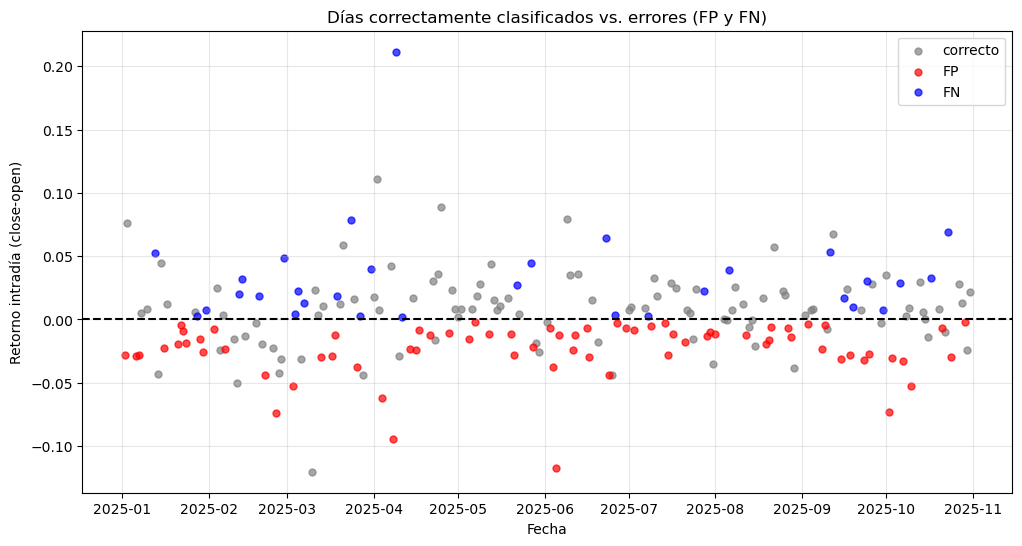

In [337]:
import matplotlib.pyplot as plt

# --- Crear dataframe de evaluación ---
df_eval = df[test_mask].copy()
df_eval["y_true"] = y_test.values
df_eval["y_pred"] = modelo_final.predict(X_test)

# Score continuo para análisis adicional (si existe)
if hasattr(modelo_final, "predict_proba"):
    df_eval["score"] = modelo_final.predict_proba(X_test)[:, 1]
elif hasattr(modelo_final, "decision_function"):
    df_eval["score"] = modelo_final.decision_function(X_test)
else:
    df_eval["score"] = None

# Clasificación del tipo de error
df_eval["error_type"] = "correcto"
df_eval.loc[(df_eval.y_true == 1) & (df_eval.y_pred == 0), "error_type"] = "FN"
df_eval.loc[(df_eval.y_true == 0) & (df_eval.y_pred == 1), "error_type"] = "FP"

# Usaremos el retorno intradía para ver extremos
df_eval["return_close_open"] = (df_eval["close"] - df_eval["open"]) / df_eval["open"]

# --- Gráfico ---
plt.figure(figsize=(12,6))
colors = {"correcto": "gray", "FP": "red", "FN": "blue"}

for etype in ["correcto", "FP", "FN"]:
    subset = df_eval[df_eval["error_type"] == etype]
    plt.scatter(
        subset["date"],
        subset["return_close_open"],
        label=etype,
        s=25,
        alpha=0.7,
        color=colors[etype]
    )

plt.axhline(0, color="black", linestyle="--")
plt.title("Días correctamente clasificados vs. errores (FP y FN)")
plt.xlabel("Fecha")
plt.ylabel("Retorno intradía (close-open)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


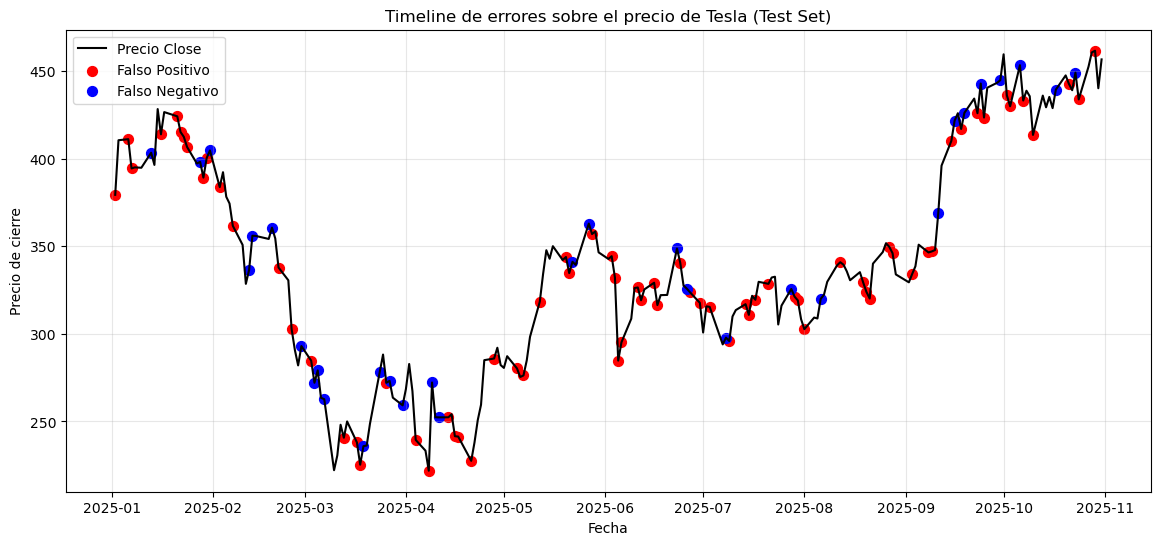

In [338]:
plt.figure(figsize=(14,6))

# Línea del precio
plt.plot(df_eval["date"], df_eval["close"], label="Precio Close", color="black", linewidth=1.5)

# Marcar FP (predijo UP pero fue DOWN)
fp = df_eval[df_eval["error_type"] == "FP"]
plt.scatter(fp["date"], fp["close"], color="red", label="Falso Positivo", s=50)

# Marcar FN (predijo DOWN pero fue UP)
fn = df_eval[df_eval["error_type"] == "FN"]
plt.scatter(fn["date"], fn["close"], color="blue", label="Falso Negativo", s=50)

plt.title("Timeline de errores sobre el precio de Tesla (Test Set)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


Aquí se ve el precio de Tesla a lo largo del período de test (2025)

Errores se agrupan en zonas de transición de tendencia. Estos puntos son conocidos por ser difíciles incluso para traders humanos.

Durante los tramos de tendencia clara (uptrend / downtrend), el modelo casi no falla. Perfectamente consistente con un modelo basado en momentum.Esto explica por qué la métrica F1 en test es tan buena: el modelo aprovecha bien las tendencias fuertes.

Aparecen clusters de FN durante subidas rápidas después de caídas fuertes.El modelo no detecta bien los rebotes (“regime shifts”). Esto ocurre porque nuestras features se basan en lags lineales.No incluyen señales como RSI, MACD o sentimiento que podrían anticipar reversals.

FP suelen aparecer cuando el precio está en máximos locales. El modelo ve momentum previo, cree que sigue subiendo… pero ocurre una corrección.Normal: el modelo no conoce niveles de sobrecompra ni catalizadores externos.

# **12. Exportar modelo**

El modelo final fue exportado como un pipeline completo, incluyendo:

* Preprocesamiento

* Modelo entrenado

Esto permitió su posterior uso en:

* Simulación financiera

* Servicio de inferencia vía API (FastAPI)

* Contenerización con Docker

In [339]:
# 3. EXPORTAR MODELO COMPLETO A DISCO

import joblib
MODEL_PATH = "best_model.pkl"

joblib.dump(modelo_final, MODEL_PATH)

print(f"Modelo exportado correctamente a: {MODEL_PATH}")


Modelo exportado correctamente a: best_model.pkl



# **Simulación de inversión con USD 10,000 en 2025**

Se utiliza una estrategia discrecional simple, basada únicamente en la predicción diaria del modelo entrenado.
El objetivo es modelar cómo habría evolucionado un portafolio de USD 10,000 aplicando las señales del modelo durante el año 2025.

La regla funciona así:

### 1. Cada día, el modelo predice si el precio subirá o bajará

Para cada día bursátil del año 2025:

* El modelo recibe los *features* técnicos (lags, momentum, volumen, indicadores, etc.).
* Produce una predicción binaria:

| `pred` | Interpretación |
| :--- | :--- |
| **1** | El modelo cree que el día terminará **en alza** (*close* > *open*) |
| **0** | El modelo cree que el día terminará **en baja o plano** |

### 2. Regla de inversión basada en la predicción

La estrategia es:

#### Si `pred == 1`: → entrar en posición larga ese día

Interpretación:
 **Comprar** al precio *open*
 **Vender** al precio *close*
 **Ganancia/pérdida del día** = retorno intradía = $(\text{close} / \text{open} - 1)$

El capital se actualiza así:
$$
\text{capital} *= (1 + \text{ret})
$$

**Ejemplo:**
Si el modelo predice UP y el retorno intradía fue $+2\%$, entonces:
$$\text{capital} = \text{capital} \times 1.02$$

#### Si `pred == 0`: → NO invertir ese día

Regla:

* No se compra nada.
* El capital simplemente se mantiene igual.
* No se gana ni se pierde.

**Objetivo:** Esto significa que la estrategia intenta **evitar días negativos** y **capturar días positivos**.


### Equity Curve (Curva de capital)

En cada día la simulación guarda:

* el **capital actualizado**
* aunque no haya *trade* ese día

Esto se usa para graficar la **curva temporal de la estrategia**. 

### 6. Métricas del Portafolio Generadas

Al final del año 2025, la simulación produce:

| Métrica | Significado |
| :--- | :--- |
| **Valor final** | Capital total al cierre del periodo |
| **Retorno total (%)** | Ganancia total acumulada del año |
| **Retorno anualizado (%)** | Estimación del retorno si la misma tasa se extendiera a un año completo |
| **Número de trades** | Total de días en los que `pred == 1` |
| **Max drawdown** | Peor caída del capital desde un máximo previo |

Filas 2025: 209
Predicciones generadas: pred
1    116
0     93
Name: count, dtype: int64

📈 RESULTADOS DE LA SIMULACIÓN 2025
----------------------------------
Capital inicial:      10,000.00 USD
Capital final:        15,154.22 USD
Retorno total:        51.54%
Retorno anualizado:   65.07%
Número de trades:     116
Max Drawdown:         -38.30%


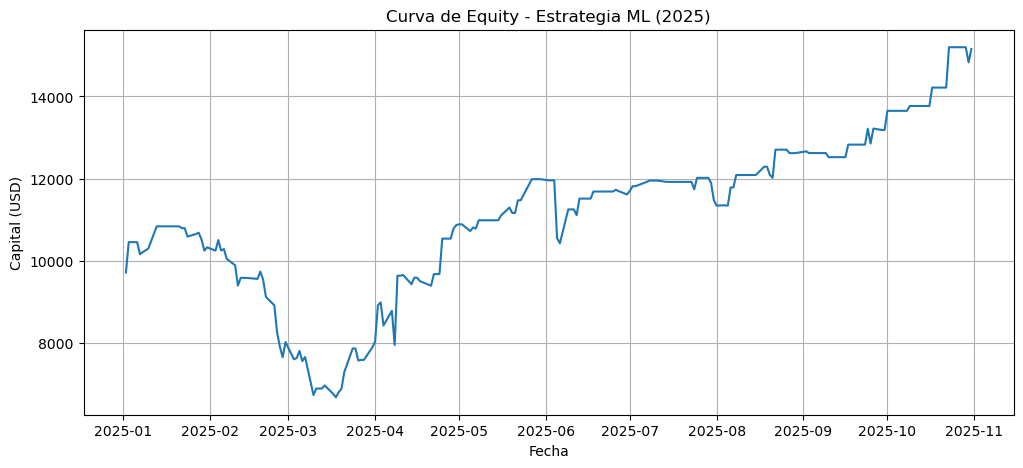

In [341]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------
# 1. Asegurar orden temporal
# -------------------------------------------------------
df = df.sort_values("date").reset_index(drop=True)

# -------------------------------------------------------
# 2. Extraer únicamente el periodo de simulación (Test REAL)
# -------------------------------------------------------
df_2025 = df[df["date"].dt.year == 2025].copy()
print("Filas 2025:", len(df_2025))

# -------------------------------------------------------
# 3. Features EXACTOS usados para entrenar el modelo
# -------------------------------------------------------
feature_cols_model = [
    "open",
    "high_lag1", "low_lag1",
    "range_lag1",

    "volume",
    "volume_lag1", "volume_lag2",
    "volume_ma5_lag1",
    "volume_rel",

    "return_prev_close_lag1",
    "return_prev_close_lag2",
    "return_close_open_lag1",

    "volatility_5d_lag1",
    "volatility_5d_lag2",

    "sma_5", "ema_5",
    "momentum_5",
    "rsi_14",

    "macd", "macd_signal",

    "boll_position",

    "dist_max_5", "dist_min_5",

    "day_of_week",
    "month"
]

# Eliminar filas con NaN (lag features)
df_2025_sim = df_2025.dropna(subset=feature_cols_model).copy()

X_sim = df_2025_sim[feature_cols_model]

# -------------------------------------------------------
# 4. Predicción con el mejor modelo final
# -------------------------------------------------------
df_2025_sim["pred"] = modelo_final.predict(X_sim)

print("Predicciones generadas:", df_2025_sim["pred"].value_counts())

# -------------------------------------------------------
# 5. Simulación de trading
# -------------------------------------------------------
capital_inicial = 10000
capital = capital_inicial
equity_curve = []

for i, row in df_2025_sim.iterrows():

    if row["pred"] == 1:
        # Retorno intradía: comprar al open y vender al close
        ret = (row["close"] / row["open"]) - 1
        capital *= (1 + ret)

    equity_curve.append(capital)

df_2025_sim["equity"] = equity_curve

# -------------------------------------------------------
# 6. Métricas del portafolio
# -------------------------------------------------------
valor_final = capital
retorno_total = (capital / capital_inicial) - 1

# Retorno anualizado (252 días de mercado)
dias = len(df_2025_sim)
retorno_anualizado = (1 + retorno_total) ** (252 / dias) - 1

# Trades
num_trades = df_2025_sim["pred"].sum()

# -------------------------------------------------------
# 7. Max Drawdown
# -------------------------------------------------------
equity = df_2025_sim["equity"].values
rolling_max = np.maximum.accumulate(equity)
drawdown = (equity - rolling_max) / rolling_max
max_drawdown = drawdown.min()

# -------------------------------------------------------
# 8. Resultados
# -------------------------------------------------------
print("\n📈 RESULTADOS DE LA SIMULACIÓN 2025")
print("----------------------------------")
print(f"Capital inicial:      {capital_inicial:,.2f} USD")
print(f"Capital final:        {valor_final:,.2f} USD")
print(f"Retorno total:        {retorno_total*100:.2f}%")
print(f"Retorno anualizado:   {retorno_anualizado*100:.2f}%")
print(f"Número de trades:     {num_trades}")
print(f"Max Drawdown:         {max_drawdown*100:.2f}%")

# -------------------------------------------------------
# 9. Curva de Equity
# -------------------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(df_2025_sim["date"], df_2025_sim["equity"])
plt.title("Curva de Equity - Estrategia ML (2025)")
plt.ylabel("Capital (USD)")
plt.xlabel("Fecha")
plt.grid(True)
plt.show()


In [347]:
mejor_modelo= []
y_sim = df_2025_sim["target_up"]
evaluar_modelo("Decision Tree", modelo_final, X_sim, y_sim, mejor_modelo)

Modelo evaluado: Decision Tree


In [348]:
best_f1 = mejor_modelo[0]["f1"]
best_auc = mejor_modelo[0]["roc_auc"]
best_model_name = mejor_modelo[0]["modelo"]

In [349]:
valor_final = capital
retorno_total = (capital / capital_inicial) - 1
max_drawdown = drawdown.min()


In [350]:
print("\n=== COMPARACIÓN: MÉTRICAS ML vs RESULTADOS FINANCIEROS ===")
print(f"Mejor modelo:          {best_model_name}")
print(f"F1 (valid/test):       {best_f1:.4f}")
print(f"ROC-AUC (valid/test):  {best_auc:.4f}")
print()
print(f"Retorno total 2025:    {retorno_total*100:.2f}%")
print(f"Máx. drawdown 2025:    {max_drawdown*100:.2f}%")



=== COMPARACIÓN: MÉTRICAS ML vs RESULTADOS FINANCIEROS ===
Mejor modelo:          Decision Tree
F1 (valid/test):       0.5792
ROC-AUC (valid/test):  0.5914

Retorno total 2025:    51.54%
Máx. drawdown 2025:    -38.30%


Estas métricas indican que el modelo tiene un comportamiento ligeramente mejor que aleatorio, pero con capacidad para detectar más días que terminan en alta que en baja. (recall relativamente alto).

A pesar de tener métricas de ML modestas, la estrategia logra un retorno anual muy alto.

**1. El F1 Score es solo ~0.59 → Pero el modelo logra +51.5% anualizado**

Esto demuestra que un buen rendimiento financiero **NO requiere un modelo con métricas perfectas**.

¿Por qué? Porque en *trading*:

* No importa tanto acertar siempre,
* Sino **acertar los días que importan más** (grandes subidas).
* Y **evitar días muy negativos**.

Es completamente posible que:

* El modelo se equivoque en muchos días pequeños.
* Pero **acierte días con retornos grandes**.
* O **evite días con caídas fuertes**.

Esto puede generar grandes beneficios netos, incluso si la precisión global parece débil. 

### ¿Un buen F1 garantiza buen retorno? → NO necesariamente

Un F1 alto ayuda, pero **no garantiza éxito financiero**.

Hay dos razones:

### 1. F1 trata a todos los días como iguales — el mercado no

En ML:

* Cada día pesa igual en la métrica.

En *trading*:

* Hay días enormes (+15%, +20%) que **definen todo el año**.
* Hay días negativos que pueden **colapsar el portafolio**.

Un modelo podría:

* Predecir muy bien días tranquilos (mejora F1).
* **Fallar en los días extremos** (arruina tu cuenta).

o viceversa.

### 2. F1 ignora magnitud del retorno (solo ve aciertos/categorías)

Ejemplo:

* Acertar un día con +1% suma poco.
* Acertar un día con **+10% cambia todo el portafolio**.
* Equivocarte en +10% pero acertar muchos +0.1% da buen F1 pero mal dinero.

El mercado es asimétrico; F1 no mide esto.

### **F1 puede dar un buen retorno:**

* Cuando el modelo **acierta las grandes subidas**

* Cuando **evita entrar en días de fuertes caídas**

* Cuando el **retorno promedio de los días predichos como “UP” es alto**

Esto parece ser el caso aquí:

> El modelo predijo **116 días UP** y capturó suficientes retornos positivos como para generar **+51%**.

### **F1 no produce un buen retorno:**

* Cuando acierta muchos días irrelevantes (retornos cerca de 0)

* Cuando **falla en días con movimientos extremos**

* Cuando la simulación ejecuta **demasiados *trades* negativos**

* Cuando predice UP en días de alta volatilidad negativa (*drawdowns* grandes)

Aquí vemos un **max *drawdown* del –38%**, lo cual confirma que:

* El modelo predijo UP en días que fueron muy malos.
* La estrategia sufrió caídas fuertes aunque el retorno final sea positivo.